In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 1012)
(4629816, 8)
validation
(621056, 1012)
(621056, 8)
test
(624904, 1012)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1012)]            0         


 dense (Dense)               (None, 1024)              1037312   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1727368 (6.59 MB)


Trainable params: 1727368 (6.59 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:49 - loss: 2.3269 - STD: 0.1006 - MAE: 0.2182

  4/463 [..............................] - ETA: 8s - loss: 2.1515 - STD: 0.0643 - MAE: 0.2166  

  7/463 [..............................] - ETA: 8s - loss: 2.1203 - STD: 0.0517 - MAE: 0.2169

 10/463 [..............................] - ETA: 8s - loss: 2.1103 - STD: 0.0483 - MAE: 0.2169

 13/463 [..............................] - ETA: 8s - loss: 2.0988 - STD: 0.0468 - MAE: 0.2167

 16/463 [>.............................] - ETA: 8s - loss: 2.0897 - STD: 0.0447 - MAE: 0.2167

 19/463 [>.............................] - ETA: 8s - loss: 2.0832 - STD: 0.0427 - MAE: 0.2167

 22/463 [>.............................] - ETA: 8s - loss: 2.0790 - STD: 0.0418 - MAE: 0.2166

 25/463 [>.............................] - ETA: 8s - loss: 2.0756 - STD: 0.0410 - MAE: 0.2166

 27/463 [>.............................] - ETA: 19s - loss: 2.0732 - STD: 0.0403 - MAE: 0.2166

 30/463 [>.............................] - ETA: 18s - loss: 2.0696 - STD: 0.0395 - MAE: 0.2166

 33/463 [=>............................] - ETA: 17s - loss: 2.0661 - STD: 0.0392 - MAE: 0.2165

 36/463 [=>............................] - ETA: 16s - loss: 2.0620 - STD: 0.0387 - MAE: 0.2164

 39/463 [=>............................] - ETA: 15s - loss: 2.0567 - STD: 0.0385 - MAE: 0.2163

 42/463 [=>............................] - ETA: 14s - loss: 2.0502 - STD: 0.0388 - MAE: 0.2160

 45/463 [=>............................] - ETA: 14s - loss: 2.0428 - STD: 0.0396 - MAE: 0.2157

 48/463 [==>...........................] - ETA: 13s - loss: 2.0343 - STD: 0.0410 - MAE: 0.2154

 51/463 [==>...........................] - ETA: 13s - loss: 2.0254 - STD: 0.0426 - MAE: 0.2149

 54/463 [==>...........................] - ETA: 13s - loss: 2.0157 - STD: 0.0443 - MAE: 0.2144

 57/463 [==>...........................] - ETA: 12s - loss: 2.0056 - STD: 0.0461 - MAE: 0.2139

 60/463 [==>...........................] - ETA: 12s - loss: 1.9954 - STD: 0.0478 - MAE: 0.2135

 63/463 [===>..........................] - ETA: 12s - loss: 1.9848 - STD: 0.0493 - MAE: 0.2130

 66/463 [===>..........................] - ETA: 11s - loss: 1.9735 - STD: 0.0509 - MAE: 0.2124

 69/463 [===>..........................] - ETA: 11s - loss: 1.9617 - STD: 0.0526 - MAE: 0.2119

 72/463 [===>..........................] - ETA: 11s - loss: 1.9505 - STD: 0.0543 - MAE: 0.2113

 75/463 [===>..........................] - ETA: 11s - loss: 1.9388 - STD: 0.0559 - MAE: 0.2107

 78/463 [====>.........................] - ETA: 10s - loss: 1.9270 - STD: 0.0576 - MAE: 0.2101

 81/463 [====>.........................] - ETA: 10s - loss: 1.9154 - STD: 0.0594 - MAE: 0.2095

 84/463 [====>.........................] - ETA: 10s - loss: 1.9032 - STD: 0.0612 - MAE: 0.2087

 87/463 [====>.........................] - ETA: 10s - loss: 1.8913 - STD: 0.0631 - MAE: 0.2080

 90/463 [====>.........................] - ETA: 10s - loss: 1.8796 - STD: 0.0650 - MAE: 0.2073

 93/463 [=====>........................] - ETA: 10s - loss: 1.8681 - STD: 0.0668 - MAE: 0.2065

 96/463 [=====>........................] - ETA: 9s - loss: 1.8566 - STD: 0.0687 - MAE: 0.2058 

 99/463 [=====>........................] - ETA: 9s - loss: 1.8454 - STD: 0.0706 - MAE: 0.2050

102/463 [=====>........................] - ETA: 9s - loss: 1.8342 - STD: 0.0723 - MAE: 0.2043

105/463 [=====>........................] - ETA: 9s - loss: 1.8233 - STD: 0.0741 - MAE: 0.2036

108/463 [=====>........................] - ETA: 9s - loss: 1.8127 - STD: 0.0759 - MAE: 0.2028

111/463 [======>.......................] - ETA: 9s - loss: 1.8028 - STD: 0.0775 - MAE: 0.2021

114/463 [======>.......................] - ETA: 9s - loss: 1.7927 - STD: 0.0792 - MAE: 0.2014

117/463 [======>.......................] - ETA: 8s - loss: 1.7829 - STD: 0.0808 - MAE: 0.2007

120/463 [======>.......................] - ETA: 8s - loss: 1.7733 - STD: 0.0824 - MAE: 0.2000

123/463 [======>.......................] - ETA: 8s - loss: 1.7640 - STD: 0.0839 - MAE: 0.1994

126/463 [=======>......................] - ETA: 8s - loss: 1.7552 - STD: 0.0854 - MAE: 0.1987

129/463 [=======>......................] - ETA: 8s - loss: 1.7464 - STD: 0.0869 - MAE: 0.1981

132/463 [=======>......................] - ETA: 8s - loss: 1.7375 - STD: 0.0883 - MAE: 0.1975

135/463 [=======>......................] - ETA: 8s - loss: 1.7290 - STD: 0.0897 - MAE: 0.1968

138/463 [=======>......................] - ETA: 8s - loss: 1.7208 - STD: 0.0910 - MAE: 0.1962

141/463 [========>.....................] - ETA: 8s - loss: 1.7126 - STD: 0.0923 - MAE: 0.1956

144/463 [========>.....................] - ETA: 7s - loss: 1.7045 - STD: 0.0936 - MAE: 0.1950

147/463 [========>.....................] - ETA: 7s - loss: 1.6966 - STD: 0.0949 - MAE: 0.1944

150/463 [========>.....................] - ETA: 7s - loss: 1.6888 - STD: 0.0962 - MAE: 0.1938

153/463 [========>.....................] - ETA: 7s - loss: 1.6815 - STD: 0.0974 - MAE: 0.1933

156/463 [=========>....................] - ETA: 7s - loss: 1.6746 - STD: 0.0986 - MAE: 0.1927

159/463 [=========>....................] - ETA: 7s - loss: 1.6676 - STD: 0.0998 - MAE: 0.1922

162/463 [=========>....................] - ETA: 7s - loss: 1.6609 - STD: 0.1009 - MAE: 0.1917

165/463 [=========>....................] - ETA: 7s - loss: 1.6543 - STD: 0.1020 - MAE: 0.1911

168/463 [=========>....................] - ETA: 7s - loss: 1.6478 - STD: 0.1031 - MAE: 0.1906

171/463 [==========>...................] - ETA: 7s - loss: 1.6413 - STD: 0.1042 - MAE: 0.1901

174/463 [==========>...................] - ETA: 7s - loss: 1.6350 - STD: 0.1052 - MAE: 0.1896

177/463 [==========>...................] - ETA: 6s - loss: 1.6287 - STD: 0.1062 - MAE: 0.1891

180/463 [==========>...................] - ETA: 6s - loss: 1.6226 - STD: 0.1072 - MAE: 0.1886

183/463 [==========>...................] - ETA: 6s - loss: 1.6167 - STD: 0.1082 - MAE: 0.1882

186/463 [===========>..................] - ETA: 6s - loss: 1.6107 - STD: 0.1092 - MAE: 0.1877

189/463 [===========>..................] - ETA: 6s - loss: 1.6050 - STD: 0.1101 - MAE: 0.1872

192/463 [===========>..................] - ETA: 6s - loss: 1.5995 - STD: 0.1110 - MAE: 0.1868

195/463 [===========>..................] - ETA: 6s - loss: 1.5940 - STD: 0.1119 - MAE: 0.1863

198/463 [===========>..................] - ETA: 6s - loss: 1.5886 - STD: 0.1128 - MAE: 0.1859

201/463 [============>.................] - ETA: 6s - loss: 1.5832 - STD: 0.1137 - MAE: 0.1855

204/463 [============>.................] - ETA: 6s - loss: 1.5782 - STD: 0.1145 - MAE: 0.1850

207/463 [============>.................] - ETA: 6s - loss: 1.5731 - STD: 0.1154 - MAE: 0.1846

210/463 [============>.................] - ETA: 5s - loss: 1.5683 - STD: 0.1162 - MAE: 0.1842

213/463 [============>.................] - ETA: 5s - loss: 1.5634 - STD: 0.1170 - MAE: 0.1838

216/463 [============>.................] - ETA: 5s - loss: 1.5586 - STD: 0.1178 - MAE: 0.1834

219/463 [=============>................] - ETA: 5s - loss: 1.5540 - STD: 0.1186 - MAE: 0.1830

222/463 [=============>................] - ETA: 5s - loss: 1.5500 - STD: 0.1193 - MAE: 0.1827

225/463 [=============>................] - ETA: 5s - loss: 1.5459 - STD: 0.1201 - MAE: 0.1823

228/463 [=============>................] - ETA: 5s - loss: 1.5419 - STD: 0.1208 - MAE: 0.1820

231/463 [=============>................] - ETA: 5s - loss: 1.5379 - STD: 0.1215 - MAE: 0.1817

234/463 [==============>...............] - ETA: 5s - loss: 1.5338 - STD: 0.1222 - MAE: 0.1813

237/463 [==============>...............] - ETA: 5s - loss: 1.5300 - STD: 0.1229 - MAE: 0.1810

240/463 [==============>...............] - ETA: 5s - loss: 1.5261 - STD: 0.1235 - MAE: 0.1807

243/463 [==============>...............] - ETA: 5s - loss: 1.5222 - STD: 0.1242 - MAE: 0.1803

246/463 [==============>...............] - ETA: 5s - loss: 1.5184 - STD: 0.1248 - MAE: 0.1800

249/463 [===============>..............] - ETA: 4s - loss: 1.5146 - STD: 0.1255 - MAE: 0.1797

252/463 [===============>..............] - ETA: 4s - loss: 1.5109 - STD: 0.1261 - MAE: 0.1794

255/463 [===============>..............] - ETA: 4s - loss: 1.5073 - STD: 0.1267 - MAE: 0.1791

258/463 [===============>..............] - ETA: 4s - loss: 1.5036 - STD: 0.1273 - MAE: 0.1788

261/463 [===============>..............] - ETA: 4s - loss: 1.4999 - STD: 0.1279 - MAE: 0.1785

264/463 [================>.............] - ETA: 4s - loss: 1.4964 - STD: 0.1285 - MAE: 0.1782

267/463 [================>.............] - ETA: 4s - loss: 1.4930 - STD: 0.1290 - MAE: 0.1779

270/463 [================>.............] - ETA: 4s - loss: 1.4894 - STD: 0.1296 - MAE: 0.1776

273/463 [================>.............] - ETA: 4s - loss: 1.4860 - STD: 0.1301 - MAE: 0.1773

276/463 [================>.............] - ETA: 4s - loss: 1.4826 - STD: 0.1307 - MAE: 0.1770

279/463 [=================>............] - ETA: 4s - loss: 1.4793 - STD: 0.1312 - MAE: 0.1767

282/463 [=================>............] - ETA: 4s - loss: 1.4760 - STD: 0.1318 - MAE: 0.1764

285/463 [=================>............] - ETA: 4s - loss: 1.4729 - STD: 0.1323 - MAE: 0.1762

288/463 [=================>............] - ETA: 4s - loss: 1.4697 - STD: 0.1328 - MAE: 0.1759

291/463 [=================>............] - ETA: 3s - loss: 1.4665 - STD: 0.1333 - MAE: 0.1756

294/463 [==================>...........] - ETA: 3s - loss: 1.4635 - STD: 0.1339 - MAE: 0.1753

297/463 [==================>...........] - ETA: 3s - loss: 1.4604 - STD: 0.1344 - MAE: 0.1751

300/463 [==================>...........] - ETA: 3s - loss: 1.4578 - STD: 0.1348 - MAE: 0.1748

303/463 [==================>...........] - ETA: 3s - loss: 1.4549 - STD: 0.1353 - MAE: 0.1746

306/463 [==================>...........] - ETA: 3s - loss: 1.4522 - STD: 0.1358 - MAE: 0.1744

309/463 [===================>..........] - ETA: 3s - loss: 1.4495 - STD: 0.1363 - MAE: 0.1741

312/463 [===================>..........] - ETA: 3s - loss: 1.4467 - STD: 0.1367 - MAE: 0.1739

315/463 [===================>..........] - ETA: 3s - loss: 1.4440 - STD: 0.1372 - MAE: 0.1736

318/463 [===================>..........] - ETA: 3s - loss: 1.4413 - STD: 0.1376 - MAE: 0.1734

321/463 [===================>..........] - ETA: 3s - loss: 1.4387 - STD: 0.1380 - MAE: 0.1732

324/463 [===================>..........] - ETA: 3s - loss: 1.4360 - STD: 0.1385 - MAE: 0.1730

327/463 [====================>.........] - ETA: 3s - loss: 1.4334 - STD: 0.1389 - MAE: 0.1727

330/463 [====================>.........] - ETA: 3s - loss: 1.4308 - STD: 0.1393 - MAE: 0.1725

333/463 [====================>.........] - ETA: 2s - loss: 1.4283 - STD: 0.1397 - MAE: 0.1723

336/463 [====================>.........] - ETA: 2s - loss: 1.4260 - STD: 0.1401 - MAE: 0.1721

339/463 [====================>.........] - ETA: 2s - loss: 1.4235 - STD: 0.1406 - MAE: 0.1719

342/463 [=====================>........] - ETA: 2s - loss: 1.4209 - STD: 0.1409 - MAE: 0.1716

345/463 [=====================>........] - ETA: 2s - loss: 1.4185 - STD: 0.1413 - MAE: 0.1714

348/463 [=====================>........] - ETA: 2s - loss: 1.4161 - STD: 0.1417 - MAE: 0.1712

351/463 [=====================>........] - ETA: 2s - loss: 1.4138 - STD: 0.1421 - MAE: 0.1710

354/463 [=====================>........] - ETA: 2s - loss: 1.4114 - STD: 0.1425 - MAE: 0.1708

357/463 [======================>.......] - ETA: 2s - loss: 1.4091 - STD: 0.1429 - MAE: 0.1706

360/463 [======================>.......] - ETA: 2s - loss: 1.4070 - STD: 0.1433 - MAE: 0.1704

363/463 [======================>.......] - ETA: 2s - loss: 1.4048 - STD: 0.1436 - MAE: 0.1702

366/463 [======================>.......] - ETA: 2s - loss: 1.4026 - STD: 0.1440 - MAE: 0.1700

369/463 [======================>.......] - ETA: 2s - loss: 1.4005 - STD: 0.1443 - MAE: 0.1698

372/463 [=======================>......] - ETA: 2s - loss: 1.3984 - STD: 0.1447 - MAE: 0.1696

375/463 [=======================>......] - ETA: 1s - loss: 1.3962 - STD: 0.1450 - MAE: 0.1695

378/463 [=======================>......] - ETA: 1s - loss: 1.3942 - STD: 0.1454 - MAE: 0.1693

381/463 [=======================>......] - ETA: 1s - loss: 1.3923 - STD: 0.1457 - MAE: 0.1691

384/463 [=======================>......] - ETA: 1s - loss: 1.3904 - STD: 0.1461 - MAE: 0.1689

387/463 [========================>.....] - ETA: 1s - loss: 1.3883 - STD: 0.1464 - MAE: 0.1688

390/463 [========================>.....] - ETA: 1s - loss: 1.3864 - STD: 0.1467 - MAE: 0.1686

393/463 [========================>.....] - ETA: 1s - loss: 1.3846 - STD: 0.1470 - MAE: 0.1684

396/463 [========================>.....] - ETA: 1s - loss: 1.3825 - STD: 0.1473 - MAE: 0.1682

399/463 [========================>.....] - ETA: 1s - loss: 1.3805 - STD: 0.1476 - MAE: 0.1681

402/463 [=========================>....] - ETA: 1s - loss: 1.3786 - STD: 0.1480 - MAE: 0.1679

405/463 [=========================>....] - ETA: 1s - loss: 1.3769 - STD: 0.1483 - MAE: 0.1677

408/463 [=========================>....] - ETA: 1s - loss: 1.3751 - STD: 0.1486 - MAE: 0.1676

411/463 [=========================>....] - ETA: 1s - loss: 1.3732 - STD: 0.1489 - MAE: 0.1674

414/463 [=========================>....] - ETA: 1s - loss: 1.3713 - STD: 0.1492 - MAE: 0.1672

417/463 [==========================>...] - ETA: 1s - loss: 1.3695 - STD: 0.1495 - MAE: 0.1671

420/463 [==========================>...] - ETA: 0s - loss: 1.3676 - STD: 0.1498 - MAE: 0.1669

423/463 [==========================>...] - ETA: 0s - loss: 1.3658 - STD: 0.1500 - MAE: 0.1668

426/463 [==========================>...] - ETA: 0s - loss: 1.3640 - STD: 0.1503 - MAE: 0.1666

429/463 [==========================>...] - ETA: 0s - loss: 1.3622 - STD: 0.1506 - MAE: 0.1664

432/463 [==========================>...] - ETA: 0s - loss: 1.3604 - STD: 0.1509 - MAE: 0.1663

434/463 [===========================>..] - ETA: 0s - loss: 1.3592 - STD: 0.1511 - MAE: 0.1662

437/463 [===========================>..] - ETA: 0s - loss: 1.3574 - STD: 0.1513 - MAE: 0.1660

440/463 [===========================>..] - ETA: 0s - loss: 1.3557 - STD: 0.1516 - MAE: 0.1659

443/463 [===========================>..] - ETA: 0s - loss: 1.3541 - STD: 0.1519 - MAE: 0.1657

446/463 [===========================>..] - ETA: 0s - loss: 1.3523 - STD: 0.1522 - MAE: 0.1656

449/463 [============================>.] - ETA: 0s - loss: 1.3506 - STD: 0.1524 - MAE: 0.1654

452/463 [============================>.] - ETA: 0s - loss: 1.3490 - STD: 0.1527 - MAE: 0.1653

455/463 [============================>.] - ETA: 0s - loss: 1.3474 - STD: 0.1530 - MAE: 0.1651

458/463 [============================>.] - ETA: 0s - loss: 1.3457 - STD: 0.1532 - MAE: 0.1650

461/463 [============================>.] - ETA: 0s - loss: 1.3443 - STD: 0.1535 - MAE: 0.1648

463/463 [==============================] - 13s 26ms/step - loss: 1.3434 - STD: 0.1536 - MAE: 0.1647 - val_loss: 1.2273 - val_STD: 0.1888 - val_MAE: 0.1500


Epoch 2/10000


  1/463 [..............................] - ETA: 23s - loss: 1.0954 - STD: 0.1943 - MAE: 0.1417

  4/463 [..............................] - ETA: 10s - loss: 1.0997 - STD: 0.1932 - MAE: 0.1426

  7/463 [..............................] - ETA: 9s - loss: 1.0952 - STD: 0.1931 - MAE: 0.1425 

 10/463 [..............................] - ETA: 9s - loss: 1.0934 - STD: 0.1930 - MAE: 0.1424

 13/463 [..............................] - ETA: 9s - loss: 1.0924 - STD: 0.1927 - MAE: 0.1425

 16/463 [>.............................] - ETA: 9s - loss: 1.0916 - STD: 0.1927 - MAE: 0.1425

 19/463 [>.............................] - ETA: 9s - loss: 1.0918 - STD: 0.1926 - MAE: 0.1425

 22/463 [>.............................] - ETA: 9s - loss: 1.0921 - STD: 0.1927 - MAE: 0.1425

 25/463 [>.............................] - ETA: 9s - loss: 1.0948 - STD: 0.1927 - MAE: 0.1426

 28/463 [>.............................] - ETA: 9s - loss: 1.0964 - STD: 0.1928 - MAE: 0.1427

 31/463 [=>............................] - ETA: 8s - loss: 1.0948 - STD: 0.1931 - MAE: 0.1425

 34/463 [=>............................] - ETA: 8s - loss: 1.0933 - STD: 0.1932 - MAE: 0.1423

 37/463 [=>............................] - ETA: 8s - loss: 1.0922 - STD: 0.1932 - MAE: 0.1423

 40/463 [=>............................] - ETA: 8s - loss: 1.0922 - STD: 0.1932 - MAE: 0.1422

 43/463 [=>............................] - ETA: 8s - loss: 1.0921 - STD: 0.1933 - MAE: 0.1422

 46/463 [=>............................] - ETA: 8s - loss: 1.0909 - STD: 0.1933 - MAE: 0.1421

 49/463 [==>...........................] - ETA: 8s - loss: 1.0902 - STD: 0.1935 - MAE: 0.1420

 52/463 [==>...........................] - ETA: 8s - loss: 1.0896 - STD: 0.1936 - MAE: 0.1420

 55/463 [==>...........................] - ETA: 8s - loss: 1.0891 - STD: 0.1937 - MAE: 0.1419

 58/463 [==>...........................] - ETA: 8s - loss: 1.0885 - STD: 0.1938 - MAE: 0.1418

 61/463 [==>...........................] - ETA: 8s - loss: 1.0886 - STD: 0.1938 - MAE: 0.1418

 64/463 [===>..........................] - ETA: 8s - loss: 1.0879 - STD: 0.1939 - MAE: 0.1418

 67/463 [===>..........................] - ETA: 8s - loss: 1.0885 - STD: 0.1940 - MAE: 0.1417

 70/463 [===>..........................] - ETA: 8s - loss: 1.0884 - STD: 0.1941 - MAE: 0.1417

 73/463 [===>..........................] - ETA: 8s - loss: 1.0883 - STD: 0.1942 - MAE: 0.1416

 76/463 [===>..........................] - ETA: 7s - loss: 1.0878 - STD: 0.1943 - MAE: 0.1416

 79/463 [====>.........................] - ETA: 7s - loss: 1.0871 - STD: 0.1943 - MAE: 0.1415

 82/463 [====>.........................] - ETA: 7s - loss: 1.0871 - STD: 0.1944 - MAE: 0.1415

 85/463 [====>.........................] - ETA: 7s - loss: 1.0865 - STD: 0.1944 - MAE: 0.1415

 88/463 [====>.........................] - ETA: 7s - loss: 1.0864 - STD: 0.1944 - MAE: 0.1415

 91/463 [====>.........................] - ETA: 7s - loss: 1.0859 - STD: 0.1944 - MAE: 0.1414

 94/463 [=====>........................] - ETA: 7s - loss: 1.0852 - STD: 0.1944 - MAE: 0.1414

 97/463 [=====>........................] - ETA: 7s - loss: 1.0843 - STD: 0.1945 - MAE: 0.1413

100/463 [=====>........................] - ETA: 7s - loss: 1.0835 - STD: 0.1946 - MAE: 0.1412

103/463 [=====>........................] - ETA: 7s - loss: 1.0828 - STD: 0.1947 - MAE: 0.1412

106/463 [=====>........................] - ETA: 7s - loss: 1.0822 - STD: 0.1947 - MAE: 0.1411

109/463 [======>.......................] - ETA: 7s - loss: 1.0821 - STD: 0.1948 - MAE: 0.1411

112/463 [======>.......................] - ETA: 7s - loss: 1.0820 - STD: 0.1948 - MAE: 0.1410

115/463 [======>.......................] - ETA: 7s - loss: 1.0813 - STD: 0.1949 - MAE: 0.1410

118/463 [======>.......................] - ETA: 7s - loss: 1.0807 - STD: 0.1950 - MAE: 0.1409

121/463 [======>.......................] - ETA: 7s - loss: 1.0800 - STD: 0.1950 - MAE: 0.1409

124/463 [=======>......................] - ETA: 6s - loss: 1.0794 - STD: 0.1951 - MAE: 0.1408

127/463 [=======>......................] - ETA: 6s - loss: 1.0789 - STD: 0.1952 - MAE: 0.1408

130/463 [=======>......................] - ETA: 6s - loss: 1.0786 - STD: 0.1952 - MAE: 0.1407

133/463 [=======>......................] - ETA: 6s - loss: 1.0780 - STD: 0.1953 - MAE: 0.1407

136/463 [=======>......................] - ETA: 6s - loss: 1.0772 - STD: 0.1954 - MAE: 0.1406

139/463 [========>.....................] - ETA: 6s - loss: 1.0767 - STD: 0.1954 - MAE: 0.1405

142/463 [========>.....................] - ETA: 6s - loss: 1.0764 - STD: 0.1955 - MAE: 0.1405

145/463 [========>.....................] - ETA: 6s - loss: 1.0761 - STD: 0.1955 - MAE: 0.1404

148/463 [========>.....................] - ETA: 6s - loss: 1.0753 - STD: 0.1956 - MAE: 0.1404

151/463 [========>.....................] - ETA: 6s - loss: 1.0748 - STD: 0.1957 - MAE: 0.1403

154/463 [========>.....................] - ETA: 6s - loss: 1.0739 - STD: 0.1957 - MAE: 0.1402

157/463 [=========>....................] - ETA: 6s - loss: 1.0734 - STD: 0.1958 - MAE: 0.1402

160/463 [=========>....................] - ETA: 6s - loss: 1.0726 - STD: 0.1959 - MAE: 0.1401

163/463 [=========>....................] - ETA: 6s - loss: 1.0721 - STD: 0.1960 - MAE: 0.1400

166/463 [=========>....................] - ETA: 6s - loss: 1.0718 - STD: 0.1961 - MAE: 0.1400

169/463 [=========>....................] - ETA: 6s - loss: 1.0713 - STD: 0.1961 - MAE: 0.1399

172/463 [==========>...................] - ETA: 6s - loss: 1.0716 - STD: 0.1962 - MAE: 0.1399

175/463 [==========>...................] - ETA: 5s - loss: 1.0712 - STD: 0.1963 - MAE: 0.1399

178/463 [==========>...................] - ETA: 5s - loss: 1.0705 - STD: 0.1963 - MAE: 0.1398

181/463 [==========>...................] - ETA: 5s - loss: 1.0701 - STD: 0.1964 - MAE: 0.1397

184/463 [==========>...................] - ETA: 5s - loss: 1.0696 - STD: 0.1965 - MAE: 0.1397

187/463 [===========>..................] - ETA: 5s - loss: 1.0691 - STD: 0.1965 - MAE: 0.1396

190/463 [===========>..................] - ETA: 5s - loss: 1.0686 - STD: 0.1966 - MAE: 0.1396

193/463 [===========>..................] - ETA: 5s - loss: 1.0680 - STD: 0.1966 - MAE: 0.1395

196/463 [===========>..................] - ETA: 5s - loss: 1.0676 - STD: 0.1966 - MAE: 0.1395

199/463 [===========>..................] - ETA: 5s - loss: 1.0671 - STD: 0.1967 - MAE: 0.1395

202/463 [============>.................] - ETA: 5s - loss: 1.0665 - STD: 0.1967 - MAE: 0.1394

205/463 [============>.................] - ETA: 5s - loss: 1.0659 - STD: 0.1968 - MAE: 0.1393

208/463 [============>.................] - ETA: 5s - loss: 1.0654 - STD: 0.1969 - MAE: 0.1393

211/463 [============>.................] - ETA: 5s - loss: 1.0648 - STD: 0.1970 - MAE: 0.1392

214/463 [============>.................] - ETA: 5s - loss: 1.0644 - STD: 0.1970 - MAE: 0.1392

217/463 [=============>................] - ETA: 5s - loss: 1.0650 - STD: 0.1971 - MAE: 0.1392

220/463 [=============>................] - ETA: 5s - loss: 1.0646 - STD: 0.1972 - MAE: 0.1391

223/463 [=============>................] - ETA: 4s - loss: 1.0642 - STD: 0.1972 - MAE: 0.1391

226/463 [=============>................] - ETA: 4s - loss: 1.0638 - STD: 0.1973 - MAE: 0.1390

229/463 [=============>................] - ETA: 4s - loss: 1.0634 - STD: 0.1974 - MAE: 0.1390

232/463 [==============>...............] - ETA: 4s - loss: 1.0629 - STD: 0.1974 - MAE: 0.1389

235/463 [==============>...............] - ETA: 4s - loss: 1.0624 - STD: 0.1975 - MAE: 0.1389

238/463 [==============>...............] - ETA: 4s - loss: 1.0617 - STD: 0.1976 - MAE: 0.1388

241/463 [==============>...............] - ETA: 4s - loss: 1.0611 - STD: 0.1976 - MAE: 0.1387

244/463 [==============>...............] - ETA: 4s - loss: 1.0606 - STD: 0.1977 - MAE: 0.1387

247/463 [===============>..............] - ETA: 4s - loss: 1.0601 - STD: 0.1977 - MAE: 0.1386

250/463 [===============>..............] - ETA: 4s - loss: 1.0596 - STD: 0.1978 - MAE: 0.1386

253/463 [===============>..............] - ETA: 4s - loss: 1.0593 - STD: 0.1979 - MAE: 0.1385

256/463 [===============>..............] - ETA: 4s - loss: 1.0588 - STD: 0.1980 - MAE: 0.1385

259/463 [===============>..............] - ETA: 4s - loss: 1.0584 - STD: 0.1980 - MAE: 0.1384

262/463 [===============>..............] - ETA: 4s - loss: 1.0578 - STD: 0.1981 - MAE: 0.1384

265/463 [================>.............] - ETA: 4s - loss: 1.0574 - STD: 0.1981 - MAE: 0.1383

268/463 [================>.............] - ETA: 4s - loss: 1.0569 - STD: 0.1982 - MAE: 0.1383

271/463 [================>.............] - ETA: 3s - loss: 1.0566 - STD: 0.1983 - MAE: 0.1382

274/463 [================>.............] - ETA: 3s - loss: 1.0560 - STD: 0.1983 - MAE: 0.1382

277/463 [================>.............] - ETA: 3s - loss: 1.0554 - STD: 0.1984 - MAE: 0.1381

280/463 [=================>............] - ETA: 3s - loss: 1.0551 - STD: 0.1984 - MAE: 0.1381

283/463 [=================>............] - ETA: 3s - loss: 1.0546 - STD: 0.1985 - MAE: 0.1380

286/463 [=================>............] - ETA: 3s - loss: 1.0541 - STD: 0.1986 - MAE: 0.1380

289/463 [=================>............] - ETA: 3s - loss: 1.0536 - STD: 0.1986 - MAE: 0.1379

292/463 [=================>............] - ETA: 3s - loss: 1.0532 - STD: 0.1987 - MAE: 0.1379

295/463 [==================>...........] - ETA: 3s - loss: 1.0528 - STD: 0.1988 - MAE: 0.1378

298/463 [==================>...........] - ETA: 3s - loss: 1.0522 - STD: 0.1988 - MAE: 0.1378

301/463 [==================>...........] - ETA: 3s - loss: 1.0516 - STD: 0.1989 - MAE: 0.1377

304/463 [==================>...........] - ETA: 3s - loss: 1.0509 - STD: 0.1990 - MAE: 0.1376

307/463 [==================>...........] - ETA: 3s - loss: 1.0504 - STD: 0.1990 - MAE: 0.1376

310/463 [===================>..........] - ETA: 3s - loss: 1.0499 - STD: 0.1991 - MAE: 0.1375

313/463 [===================>..........] - ETA: 3s - loss: 1.0494 - STD: 0.1992 - MAE: 0.1375

316/463 [===================>..........] - ETA: 3s - loss: 1.0488 - STD: 0.1992 - MAE: 0.1374

319/463 [===================>..........] - ETA: 2s - loss: 1.0483 - STD: 0.1993 - MAE: 0.1374

322/463 [===================>..........] - ETA: 2s - loss: 1.0484 - STD: 0.1994 - MAE: 0.1373

325/463 [====================>.........] - ETA: 2s - loss: 1.0483 - STD: 0.1995 - MAE: 0.1373

328/463 [====================>.........] - ETA: 2s - loss: 1.0483 - STD: 0.1995 - MAE: 0.1373

331/463 [====================>.........] - ETA: 2s - loss: 1.0479 - STD: 0.1996 - MAE: 0.1372

334/463 [====================>.........] - ETA: 2s - loss: 1.0474 - STD: 0.1997 - MAE: 0.1372

337/463 [====================>.........] - ETA: 2s - loss: 1.0469 - STD: 0.1997 - MAE: 0.1371

340/463 [=====================>........] - ETA: 2s - loss: 1.0464 - STD: 0.1998 - MAE: 0.1371

343/463 [=====================>........] - ETA: 2s - loss: 1.0460 - STD: 0.1998 - MAE: 0.1370

346/463 [=====================>........] - ETA: 2s - loss: 1.0455 - STD: 0.1999 - MAE: 0.1370

349/463 [=====================>........] - ETA: 2s - loss: 1.0452 - STD: 0.1999 - MAE: 0.1369

352/463 [=====================>........] - ETA: 2s - loss: 1.0447 - STD: 0.2000 - MAE: 0.1369

355/463 [======================>.......] - ETA: 2s - loss: 1.0442 - STD: 0.2001 - MAE: 0.1368

358/463 [======================>.......] - ETA: 2s - loss: 1.0437 - STD: 0.2001 - MAE: 0.1368

361/463 [======================>.......] - ETA: 2s - loss: 1.0432 - STD: 0.2002 - MAE: 0.1367

364/463 [======================>.......] - ETA: 2s - loss: 1.0428 - STD: 0.2002 - MAE: 0.1367

367/463 [======================>.......] - ETA: 1s - loss: 1.0423 - STD: 0.2003 - MAE: 0.1366

370/463 [======================>.......] - ETA: 1s - loss: 1.0418 - STD: 0.2004 - MAE: 0.1366

373/463 [=======================>......] - ETA: 1s - loss: 1.0415 - STD: 0.2004 - MAE: 0.1365

376/463 [=======================>......] - ETA: 1s - loss: 1.0411 - STD: 0.2005 - MAE: 0.1365

379/463 [=======================>......] - ETA: 1s - loss: 1.0406 - STD: 0.2005 - MAE: 0.1364

382/463 [=======================>......] - ETA: 1s - loss: 1.0401 - STD: 0.2006 - MAE: 0.1364

385/463 [=======================>......] - ETA: 1s - loss: 1.0398 - STD: 0.2007 - MAE: 0.1363

388/463 [========================>.....] - ETA: 1s - loss: 1.0395 - STD: 0.2007 - MAE: 0.1363

391/463 [========================>.....] - ETA: 1s - loss: 1.0394 - STD: 0.2008 - MAE: 0.1362

394/463 [========================>.....] - ETA: 1s - loss: 1.0390 - STD: 0.2008 - MAE: 0.1362

397/463 [========================>.....] - ETA: 1s - loss: 1.0387 - STD: 0.2009 - MAE: 0.1362

400/463 [========================>.....] - ETA: 1s - loss: 1.0385 - STD: 0.2010 - MAE: 0.1361

403/463 [=========================>....] - ETA: 1s - loss: 1.0382 - STD: 0.2010 - MAE: 0.1361

406/463 [=========================>....] - ETA: 1s - loss: 1.0378 - STD: 0.2011 - MAE: 0.1360

409/463 [=========================>....] - ETA: 1s - loss: 1.0374 - STD: 0.2011 - MAE: 0.1360

412/463 [=========================>....] - ETA: 1s - loss: 1.0372 - STD: 0.2012 - MAE: 0.1360

415/463 [=========================>....] - ETA: 0s - loss: 1.0367 - STD: 0.2012 - MAE: 0.1359

418/463 [==========================>...] - ETA: 0s - loss: 1.0362 - STD: 0.2013 - MAE: 0.1359

421/463 [==========================>...] - ETA: 0s - loss: 1.0358 - STD: 0.2013 - MAE: 0.1358

424/463 [==========================>...] - ETA: 0s - loss: 1.0354 - STD: 0.2014 - MAE: 0.1358

427/463 [==========================>...] - ETA: 0s - loss: 1.0350 - STD: 0.2015 - MAE: 0.1357

430/463 [==========================>...] - ETA: 0s - loss: 1.0345 - STD: 0.2015 - MAE: 0.1357

433/463 [===========================>..] - ETA: 0s - loss: 1.0341 - STD: 0.2016 - MAE: 0.1356

436/463 [===========================>..] - ETA: 0s - loss: 1.0337 - STD: 0.2016 - MAE: 0.1356

439/463 [===========================>..] - ETA: 0s - loss: 1.0333 - STD: 0.2017 - MAE: 0.1355

442/463 [===========================>..] - ETA: 0s - loss: 1.0330 - STD: 0.2017 - MAE: 0.1355

445/463 [===========================>..] - ETA: 0s - loss: 1.0327 - STD: 0.2018 - MAE: 0.1355

448/463 [============================>.] - ETA: 0s - loss: 1.0326 - STD: 0.2018 - MAE: 0.1354

451/463 [============================>.] - ETA: 0s - loss: 1.0323 - STD: 0.2019 - MAE: 0.1354

454/463 [============================>.] - ETA: 0s - loss: 1.0320 - STD: 0.2019 - MAE: 0.1354

457/463 [============================>.] - ETA: 0s - loss: 1.0316 - STD: 0.2020 - MAE: 0.1353

460/463 [============================>.] - ETA: 0s - loss: 1.0312 - STD: 0.2020 - MAE: 0.1353

463/463 [==============================] - ETA: 0s - loss: 1.0308 - STD: 0.2021 - MAE: 0.1352

463/463 [==============================] - 11s 23ms/step - loss: 1.0308 - STD: 0.2021 - MAE: 0.1352 - val_loss: 1.1276 - val_STD: 0.2064 - val_MAE: 0.1392


Epoch 3/10000


  1/463 [..............................] - ETA: 28s - loss: 0.9696 - STD: 0.2107 - MAE: 0.1282

  4/463 [..............................] - ETA: 9s - loss: 0.9637 - STD: 0.2100 - MAE: 0.1281 

  7/463 [..............................] - ETA: 9s - loss: 0.9627 - STD: 0.2098 - MAE: 0.1282

 10/463 [..............................] - ETA: 9s - loss: 0.9640 - STD: 0.2100 - MAE: 0.1282

 13/463 [..............................] - ETA: 9s - loss: 0.9691 - STD: 0.2103 - MAE: 0.1283

 16/463 [>.............................] - ETA: 9s - loss: 0.9734 - STD: 0.2105 - MAE: 0.1285

 19/463 [>.............................] - ETA: 9s - loss: 0.9720 - STD: 0.2106 - MAE: 0.1284

 22/463 [>.............................] - ETA: 9s - loss: 0.9726 - STD: 0.2105 - MAE: 0.1284

 25/463 [>.............................] - ETA: 9s - loss: 0.9722 - STD: 0.2106 - MAE: 0.1284

 28/463 [>.............................] - ETA: 9s - loss: 0.9746 - STD: 0.2106 - MAE: 0.1285

 31/463 [=>............................] - ETA: 9s - loss: 0.9785 - STD: 0.2107 - MAE: 0.1287

 34/463 [=>............................] - ETA: 8s - loss: 0.9807 - STD: 0.2108 - MAE: 0.1288

 37/463 [=>............................] - ETA: 8s - loss: 0.9832 - STD: 0.2108 - MAE: 0.1289

 40/463 [=>............................] - ETA: 8s - loss: 0.9836 - STD: 0.2106 - MAE: 0.1290

 43/463 [=>............................] - ETA: 8s - loss: 0.9821 - STD: 0.2107 - MAE: 0.1289

 46/463 [=>............................] - ETA: 8s - loss: 0.9815 - STD: 0.2107 - MAE: 0.1289

 49/463 [==>...........................] - ETA: 8s - loss: 0.9810 - STD: 0.2107 - MAE: 0.1289

 52/463 [==>...........................] - ETA: 8s - loss: 0.9802 - STD: 0.2107 - MAE: 0.1288

 55/463 [==>...........................] - ETA: 8s - loss: 0.9791 - STD: 0.2106 - MAE: 0.1288

 58/463 [==>...........................] - ETA: 8s - loss: 0.9779 - STD: 0.2106 - MAE: 0.1287

 61/463 [==>...........................] - ETA: 8s - loss: 0.9773 - STD: 0.2106 - MAE: 0.1287

 64/463 [===>..........................] - ETA: 8s - loss: 0.9763 - STD: 0.2107 - MAE: 0.1286

 67/463 [===>..........................] - ETA: 8s - loss: 0.9762 - STD: 0.2107 - MAE: 0.1286

 70/463 [===>..........................] - ETA: 8s - loss: 0.9758 - STD: 0.2108 - MAE: 0.1285

 73/463 [===>..........................] - ETA: 8s - loss: 0.9756 - STD: 0.2108 - MAE: 0.1285

 76/463 [===>..........................] - ETA: 8s - loss: 0.9748 - STD: 0.2108 - MAE: 0.1284

 79/463 [====>.........................] - ETA: 7s - loss: 0.9742 - STD: 0.2109 - MAE: 0.1284

 83/463 [====>.........................] - ETA: 7s - loss: 0.9729 - STD: 0.2110 - MAE: 0.1283

 87/463 [====>.........................] - ETA: 7s - loss: 0.9725 - STD: 0.2110 - MAE: 0.1282

 91/463 [====>.........................] - ETA: 7s - loss: 0.9720 - STD: 0.2111 - MAE: 0.1282

 95/463 [=====>........................] - ETA: 7s - loss: 0.9719 - STD: 0.2111 - MAE: 0.1281

 98/463 [=====>........................] - ETA: 7s - loss: 0.9716 - STD: 0.2112 - MAE: 0.1281

101/463 [=====>........................] - ETA: 7s - loss: 0.9711 - STD: 0.2113 - MAE: 0.1280

104/463 [=====>........................] - ETA: 7s - loss: 0.9706 - STD: 0.2113 - MAE: 0.1280

107/463 [=====>........................] - ETA: 7s - loss: 0.9702 - STD: 0.2113 - MAE: 0.1280

110/463 [======>.......................] - ETA: 6s - loss: 0.9698 - STD: 0.2113 - MAE: 0.1279

114/463 [======>.......................] - ETA: 6s - loss: 0.9693 - STD: 0.2114 - MAE: 0.1279

117/463 [======>.......................] - ETA: 6s - loss: 0.9686 - STD: 0.2114 - MAE: 0.1278

121/463 [======>.......................] - ETA: 6s - loss: 0.9679 - STD: 0.2115 - MAE: 0.1277

124/463 [=======>......................] - ETA: 6s - loss: 0.9674 - STD: 0.2115 - MAE: 0.1277

128/463 [=======>......................] - ETA: 6s - loss: 0.9682 - STD: 0.2116 - MAE: 0.1277

131/463 [=======>......................] - ETA: 6s - loss: 0.9682 - STD: 0.2117 - MAE: 0.1277

134/463 [=======>......................] - ETA: 6s - loss: 0.9681 - STD: 0.2117 - MAE: 0.1276

137/463 [=======>......................] - ETA: 6s - loss: 0.9682 - STD: 0.2118 - MAE: 0.1276

140/463 [========>.....................] - ETA: 6s - loss: 0.9684 - STD: 0.2118 - MAE: 0.1276

144/463 [========>.....................] - ETA: 6s - loss: 0.9689 - STD: 0.2118 - MAE: 0.1276

148/463 [========>.....................] - ETA: 5s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1276

151/463 [========>.....................] - ETA: 5s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1276

155/463 [=========>....................] - ETA: 5s - loss: 0.9687 - STD: 0.2119 - MAE: 0.1276

158/463 [=========>....................] - ETA: 5s - loss: 0.9684 - STD: 0.2119 - MAE: 0.1276

161/463 [=========>....................] - ETA: 5s - loss: 0.9680 - STD: 0.2120 - MAE: 0.1275

164/463 [=========>....................] - ETA: 5s - loss: 0.9677 - STD: 0.2120 - MAE: 0.1275

167/463 [=========>....................] - ETA: 5s - loss: 0.9673 - STD: 0.2120 - MAE: 0.1275

170/463 [==========>...................] - ETA: 5s - loss: 0.9670 - STD: 0.2120 - MAE: 0.1275

174/463 [==========>...................] - ETA: 5s - loss: 0.9666 - STD: 0.2121 - MAE: 0.1274

177/463 [==========>...................] - ETA: 5s - loss: 0.9663 - STD: 0.2121 - MAE: 0.1274

180/463 [==========>...................] - ETA: 5s - loss: 0.9660 - STD: 0.2121 - MAE: 0.1273

183/463 [==========>...................] - ETA: 5s - loss: 0.9656 - STD: 0.2121 - MAE: 0.1273

186/463 [===========>..................] - ETA: 5s - loss: 0.9651 - STD: 0.2122 - MAE: 0.1273

189/463 [===========>..................] - ETA: 5s - loss: 0.9648 - STD: 0.2122 - MAE: 0.1272

192/463 [===========>..................] - ETA: 5s - loss: 0.9646 - STD: 0.2122 - MAE: 0.1272

195/463 [===========>..................] - ETA: 4s - loss: 0.9646 - STD: 0.2123 - MAE: 0.1272

198/463 [===========>..................] - ETA: 4s - loss: 0.9644 - STD: 0.2123 - MAE: 0.1272

201/463 [============>.................] - ETA: 4s - loss: 0.9643 - STD: 0.2123 - MAE: 0.1271

204/463 [============>.................] - ETA: 4s - loss: 0.9639 - STD: 0.2124 - MAE: 0.1271

207/463 [============>.................] - ETA: 4s - loss: 0.9637 - STD: 0.2124 - MAE: 0.1271

210/463 [============>.................] - ETA: 4s - loss: 0.9632 - STD: 0.2124 - MAE: 0.1271

213/463 [============>.................] - ETA: 4s - loss: 0.9629 - STD: 0.2124 - MAE: 0.1270

216/463 [============>.................] - ETA: 4s - loss: 0.9627 - STD: 0.2125 - MAE: 0.1270

219/463 [=============>................] - ETA: 4s - loss: 0.9623 - STD: 0.2125 - MAE: 0.1270

222/463 [=============>................] - ETA: 4s - loss: 0.9618 - STD: 0.2125 - MAE: 0.1269

225/463 [=============>................] - ETA: 4s - loss: 0.9613 - STD: 0.2126 - MAE: 0.1269

228/463 [=============>................] - ETA: 4s - loss: 0.9609 - STD: 0.2126 - MAE: 0.1268

232/463 [==============>...............] - ETA: 4s - loss: 0.9603 - STD: 0.2127 - MAE: 0.1268

235/463 [==============>...............] - ETA: 4s - loss: 0.9600 - STD: 0.2127 - MAE: 0.1267

238/463 [==============>...............] - ETA: 4s - loss: 0.9597 - STD: 0.2128 - MAE: 0.1267

242/463 [==============>...............] - ETA: 4s - loss: 0.9596 - STD: 0.2128 - MAE: 0.1267

245/463 [==============>...............] - ETA: 3s - loss: 0.9592 - STD: 0.2128 - MAE: 0.1266

248/463 [===============>..............] - ETA: 3s - loss: 0.9589 - STD: 0.2129 - MAE: 0.1266

251/463 [===============>..............] - ETA: 3s - loss: 0.9589 - STD: 0.2129 - MAE: 0.1266

254/463 [===============>..............] - ETA: 3s - loss: 0.9590 - STD: 0.2129 - MAE: 0.1266

257/463 [===============>..............] - ETA: 3s - loss: 0.9587 - STD: 0.2130 - MAE: 0.1266

260/463 [===============>..............] - ETA: 3s - loss: 0.9587 - STD: 0.2130 - MAE: 0.1265

263/463 [================>.............] - ETA: 3s - loss: 0.9584 - STD: 0.2131 - MAE: 0.1265

266/463 [================>.............] - ETA: 3s - loss: 0.9584 - STD: 0.2131 - MAE: 0.1265

269/463 [================>.............] - ETA: 3s - loss: 0.9581 - STD: 0.2131 - MAE: 0.1265

272/463 [================>.............] - ETA: 3s - loss: 0.9579 - STD: 0.2132 - MAE: 0.1264

275/463 [================>.............] - ETA: 3s - loss: 0.9576 - STD: 0.2132 - MAE: 0.1264

278/463 [=================>............] - ETA: 3s - loss: 0.9575 - STD: 0.2132 - MAE: 0.1264

281/463 [=================>............] - ETA: 3s - loss: 0.9573 - STD: 0.2132 - MAE: 0.1264

284/463 [=================>............] - ETA: 3s - loss: 0.9570 - STD: 0.2133 - MAE: 0.1263

287/463 [=================>............] - ETA: 3s - loss: 0.9568 - STD: 0.2133 - MAE: 0.1263

291/463 [=================>............] - ETA: 3s - loss: 0.9565 - STD: 0.2133 - MAE: 0.1263

294/463 [==================>...........] - ETA: 3s - loss: 0.9563 - STD: 0.2134 - MAE: 0.1262

298/463 [==================>...........] - ETA: 2s - loss: 0.9561 - STD: 0.2134 - MAE: 0.1262

302/463 [==================>...........] - ETA: 2s - loss: 0.9557 - STD: 0.2134 - MAE: 0.1262

305/463 [==================>...........] - ETA: 2s - loss: 0.9556 - STD: 0.2135 - MAE: 0.1262

308/463 [==================>...........] - ETA: 2s - loss: 0.9554 - STD: 0.2135 - MAE: 0.1261

311/463 [===================>..........] - ETA: 2s - loss: 0.9552 - STD: 0.2135 - MAE: 0.1261

314/463 [===================>..........] - ETA: 2s - loss: 0.9549 - STD: 0.2136 - MAE: 0.1261

317/463 [===================>..........] - ETA: 2s - loss: 0.9548 - STD: 0.2136 - MAE: 0.1261

320/463 [===================>..........] - ETA: 2s - loss: 0.9546 - STD: 0.2136 - MAE: 0.1260

323/463 [===================>..........] - ETA: 2s - loss: 0.9544 - STD: 0.2137 - MAE: 0.1260

326/463 [====================>.........] - ETA: 2s - loss: 0.9541 - STD: 0.2137 - MAE: 0.1260

329/463 [====================>.........] - ETA: 2s - loss: 0.9539 - STD: 0.2137 - MAE: 0.1259

332/463 [====================>.........] - ETA: 2s - loss: 0.9536 - STD: 0.2138 - MAE: 0.1259

335/463 [====================>.........] - ETA: 2s - loss: 0.9534 - STD: 0.2138 - MAE: 0.1259

338/463 [====================>.........] - ETA: 2s - loss: 0.9530 - STD: 0.2138 - MAE: 0.1259

341/463 [=====================>........] - ETA: 2s - loss: 0.9527 - STD: 0.2139 - MAE: 0.1258

344/463 [=====================>........] - ETA: 2s - loss: 0.9522 - STD: 0.2139 - MAE: 0.1258

347/463 [=====================>........] - ETA: 2s - loss: 0.9521 - STD: 0.2139 - MAE: 0.1258

351/463 [=====================>........] - ETA: 2s - loss: 0.9517 - STD: 0.2140 - MAE: 0.1257

354/463 [=====================>........] - ETA: 1s - loss: 0.9513 - STD: 0.2140 - MAE: 0.1257

357/463 [======================>.......] - ETA: 1s - loss: 0.9510 - STD: 0.2140 - MAE: 0.1256

361/463 [======================>.......] - ETA: 1s - loss: 0.9506 - STD: 0.2141 - MAE: 0.1256

364/463 [======================>.......] - ETA: 1s - loss: 0.9503 - STD: 0.2141 - MAE: 0.1256

368/463 [======================>.......] - ETA: 1s - loss: 0.9499 - STD: 0.2141 - MAE: 0.1255

371/463 [=======================>......] - ETA: 1s - loss: 0.9500 - STD: 0.2142 - MAE: 0.1255

374/463 [=======================>......] - ETA: 1s - loss: 0.9498 - STD: 0.2142 - MAE: 0.1255

377/463 [=======================>......] - ETA: 1s - loss: 0.9496 - STD: 0.2142 - MAE: 0.1255

380/463 [=======================>......] - ETA: 1s - loss: 0.9494 - STD: 0.2143 - MAE: 0.1254

383/463 [=======================>......] - ETA: 1s - loss: 0.9492 - STD: 0.2143 - MAE: 0.1254

387/463 [========================>.....] - ETA: 1s - loss: 0.9489 - STD: 0.2143 - MAE: 0.1254

391/463 [========================>.....] - ETA: 1s - loss: 0.9485 - STD: 0.2144 - MAE: 0.1253

394/463 [========================>.....] - ETA: 1s - loss: 0.9485 - STD: 0.2144 - MAE: 0.1253

397/463 [========================>.....] - ETA: 1s - loss: 0.9483 - STD: 0.2144 - MAE: 0.1253

400/463 [========================>.....] - ETA: 1s - loss: 0.9481 - STD: 0.2145 - MAE: 0.1253

403/463 [=========================>....] - ETA: 1s - loss: 0.9479 - STD: 0.2145 - MAE: 0.1253

406/463 [=========================>....] - ETA: 1s - loss: 0.9480 - STD: 0.2145 - MAE: 0.1252

409/463 [=========================>....] - ETA: 0s - loss: 0.9478 - STD: 0.2146 - MAE: 0.1252

412/463 [=========================>....] - ETA: 0s - loss: 0.9476 - STD: 0.2146 - MAE: 0.1252

415/463 [=========================>....] - ETA: 0s - loss: 0.9475 - STD: 0.2146 - MAE: 0.1252

418/463 [==========================>...] - ETA: 0s - loss: 0.9474 - STD: 0.2146 - MAE: 0.1252

421/463 [==========================>...] - ETA: 0s - loss: 0.9472 - STD: 0.2146 - MAE: 0.1251

424/463 [==========================>...] - ETA: 0s - loss: 0.9469 - STD: 0.2147 - MAE: 0.1251

427/463 [==========================>...] - ETA: 0s - loss: 0.9468 - STD: 0.2147 - MAE: 0.1251

430/463 [==========================>...] - ETA: 0s - loss: 0.9465 - STD: 0.2147 - MAE: 0.1251

434/463 [===========================>..] - ETA: 0s - loss: 0.9463 - STD: 0.2147 - MAE: 0.1251

437/463 [===========================>..] - ETA: 0s - loss: 0.9461 - STD: 0.2148 - MAE: 0.1250

441/463 [===========================>..] - ETA: 0s - loss: 0.9458 - STD: 0.2148 - MAE: 0.1250

445/463 [===========================>..] - ETA: 0s - loss: 0.9456 - STD: 0.2148 - MAE: 0.1250

449/463 [============================>.] - ETA: 0s - loss: 0.9453 - STD: 0.2149 - MAE: 0.1249

453/463 [============================>.] - ETA: 0s - loss: 0.9451 - STD: 0.2149 - MAE: 0.1249

457/463 [============================>.] - ETA: 0s - loss: 0.9449 - STD: 0.2149 - MAE: 0.1249

460/463 [============================>.] - ETA: 0s - loss: 0.9447 - STD: 0.2150 - MAE: 0.1249

463/463 [==============================] - 10s 21ms/step - loss: 0.9445 - STD: 0.2150 - MAE: 0.1248 - val_loss: 1.1132 - val_STD: 0.2132 - val_MAE: 0.1361


Epoch 4/10000


  1/463 [..............................] - ETA: 22s - loss: 0.9049 - STD: 0.2181 - MAE: 0.1211

  4/463 [..............................] - ETA: 10s - loss: 0.9062 - STD: 0.2190 - MAE: 0.1208

  7/463 [..............................] - ETA: 9s - loss: 0.9062 - STD: 0.2191 - MAE: 0.1208 

 10/463 [..............................] - ETA: 9s - loss: 0.9093 - STD: 0.2187 - MAE: 0.1212

 13/463 [..............................] - ETA: 9s - loss: 0.9081 - STD: 0.2189 - MAE: 0.1210

 16/463 [>.............................] - ETA: 9s - loss: 0.9057 - STD: 0.2190 - MAE: 0.1208

 19/463 [>.............................] - ETA: 9s - loss: 0.9036 - STD: 0.2191 - MAE: 0.1206

 22/463 [>.............................] - ETA: 9s - loss: 0.9016 - STD: 0.2193 - MAE: 0.1204

 25/463 [>.............................] - ETA: 9s - loss: 0.8999 - STD: 0.2194 - MAE: 0.1202

 28/463 [>.............................] - ETA: 9s - loss: 0.9003 - STD: 0.2195 - MAE: 0.1202

 31/463 [=>............................] - ETA: 8s - loss: 0.9013 - STD: 0.2196 - MAE: 0.1202

 34/463 [=>............................] - ETA: 8s - loss: 0.9008 - STD: 0.2195 - MAE: 0.1202

 37/463 [=>............................] - ETA: 8s - loss: 0.9022 - STD: 0.2197 - MAE: 0.1202

 40/463 [=>............................] - ETA: 8s - loss: 0.9025 - STD: 0.2197 - MAE: 0.1202

 43/463 [=>............................] - ETA: 8s - loss: 0.9036 - STD: 0.2198 - MAE: 0.1203

 46/463 [=>............................] - ETA: 8s - loss: 0.9047 - STD: 0.2198 - MAE: 0.1203

 49/463 [==>...........................] - ETA: 8s - loss: 0.9059 - STD: 0.2199 - MAE: 0.1204

 52/463 [==>...........................] - ETA: 8s - loss: 0.9056 - STD: 0.2199 - MAE: 0.1204

 55/463 [==>...........................] - ETA: 8s - loss: 0.9052 - STD: 0.2199 - MAE: 0.1203

 58/463 [==>...........................] - ETA: 8s - loss: 0.9044 - STD: 0.2200 - MAE: 0.1203

 61/463 [==>...........................] - ETA: 8s - loss: 0.9039 - STD: 0.2200 - MAE: 0.1203

 64/463 [===>..........................] - ETA: 8s - loss: 0.9036 - STD: 0.2200 - MAE: 0.1202

 67/463 [===>..........................] - ETA: 8s - loss: 0.9025 - STD: 0.2200 - MAE: 0.1201

 70/463 [===>..........................] - ETA: 8s - loss: 0.9020 - STD: 0.2200 - MAE: 0.1201

 73/463 [===>..........................] - ETA: 8s - loss: 0.9014 - STD: 0.2201 - MAE: 0.1200

 76/463 [===>..........................] - ETA: 8s - loss: 0.9014 - STD: 0.2201 - MAE: 0.1200

 79/463 [====>.........................] - ETA: 7s - loss: 0.9012 - STD: 0.2201 - MAE: 0.1200

 82/463 [====>.........................] - ETA: 7s - loss: 0.9019 - STD: 0.2201 - MAE: 0.1200

 85/463 [====>.........................] - ETA: 7s - loss: 0.9021 - STD: 0.2202 - MAE: 0.1200

 88/463 [====>.........................] - ETA: 7s - loss: 0.9022 - STD: 0.2202 - MAE: 0.1200

 91/463 [====>.........................] - ETA: 7s - loss: 0.9023 - STD: 0.2202 - MAE: 0.1200

 94/463 [=====>........................] - ETA: 7s - loss: 0.9017 - STD: 0.2203 - MAE: 0.1200

 97/463 [=====>........................] - ETA: 7s - loss: 0.9018 - STD: 0.2203 - MAE: 0.1200

100/463 [=====>........................] - ETA: 7s - loss: 0.9016 - STD: 0.2203 - MAE: 0.1200

103/463 [=====>........................] - ETA: 7s - loss: 0.9011 - STD: 0.2203 - MAE: 0.1199

106/463 [=====>........................] - ETA: 7s - loss: 0.9006 - STD: 0.2204 - MAE: 0.1199

109/463 [======>.......................] - ETA: 7s - loss: 0.9002 - STD: 0.2204 - MAE: 0.1198

112/463 [======>.......................] - ETA: 7s - loss: 0.9000 - STD: 0.2204 - MAE: 0.1198

115/463 [======>.......................] - ETA: 7s - loss: 0.8998 - STD: 0.2204 - MAE: 0.1198

118/463 [======>.......................] - ETA: 7s - loss: 0.8998 - STD: 0.2205 - MAE: 0.1198

121/463 [======>.......................] - ETA: 7s - loss: 0.8996 - STD: 0.2205 - MAE: 0.1197

124/463 [=======>......................] - ETA: 7s - loss: 0.8996 - STD: 0.2205 - MAE: 0.1197

127/463 [=======>......................] - ETA: 7s - loss: 0.8995 - STD: 0.2206 - MAE: 0.1197

130/463 [=======>......................] - ETA: 6s - loss: 0.8993 - STD: 0.2206 - MAE: 0.1197

133/463 [=======>......................] - ETA: 6s - loss: 0.8993 - STD: 0.2206 - MAE: 0.1197

136/463 [=======>......................] - ETA: 6s - loss: 0.8995 - STD: 0.2206 - MAE: 0.1197

139/463 [========>.....................] - ETA: 6s - loss: 0.8992 - STD: 0.2207 - MAE: 0.1196

142/463 [========>.....................] - ETA: 6s - loss: 0.8994 - STD: 0.2207 - MAE: 0.1196

145/463 [========>.....................] - ETA: 6s - loss: 0.8995 - STD: 0.2207 - MAE: 0.1196

148/463 [========>.....................] - ETA: 6s - loss: 0.8999 - STD: 0.2208 - MAE: 0.1196

151/463 [========>.....................] - ETA: 6s - loss: 0.8998 - STD: 0.2208 - MAE: 0.1196

154/463 [========>.....................] - ETA: 6s - loss: 0.8999 - STD: 0.2208 - MAE: 0.1196

157/463 [=========>....................] - ETA: 6s - loss: 0.8998 - STD: 0.2208 - MAE: 0.1196

160/463 [=========>....................] - ETA: 6s - loss: 0.8997 - STD: 0.2208 - MAE: 0.1196

163/463 [=========>....................] - ETA: 6s - loss: 0.8998 - STD: 0.2208 - MAE: 0.1196

166/463 [=========>....................] - ETA: 6s - loss: 0.8997 - STD: 0.2208 - MAE: 0.1196

169/463 [=========>....................] - ETA: 6s - loss: 0.8995 - STD: 0.2208 - MAE: 0.1196

172/463 [==========>...................] - ETA: 6s - loss: 0.8995 - STD: 0.2209 - MAE: 0.1196

175/463 [==========>...................] - ETA: 6s - loss: 0.8991 - STD: 0.2209 - MAE: 0.1195

178/463 [==========>...................] - ETA: 5s - loss: 0.8989 - STD: 0.2209 - MAE: 0.1195

181/463 [==========>...................] - ETA: 5s - loss: 0.8985 - STD: 0.2209 - MAE: 0.1195

184/463 [==========>...................] - ETA: 5s - loss: 0.8983 - STD: 0.2209 - MAE: 0.1195

187/463 [===========>..................] - ETA: 5s - loss: 0.8979 - STD: 0.2209 - MAE: 0.1194

190/463 [===========>..................] - ETA: 5s - loss: 0.8977 - STD: 0.2209 - MAE: 0.1194

193/463 [===========>..................] - ETA: 5s - loss: 0.8976 - STD: 0.2210 - MAE: 0.1194

196/463 [===========>..................] - ETA: 5s - loss: 0.8973 - STD: 0.2210 - MAE: 0.1194

199/463 [===========>..................] - ETA: 5s - loss: 0.8970 - STD: 0.2210 - MAE: 0.1194

202/463 [============>.................] - ETA: 5s - loss: 0.8968 - STD: 0.2210 - MAE: 0.1193

205/463 [============>.................] - ETA: 5s - loss: 0.8965 - STD: 0.2211 - MAE: 0.1193

208/463 [============>.................] - ETA: 5s - loss: 0.8969 - STD: 0.2211 - MAE: 0.1193

211/463 [============>.................] - ETA: 5s - loss: 0.8967 - STD: 0.2211 - MAE: 0.1193

214/463 [============>.................] - ETA: 5s - loss: 0.8972 - STD: 0.2212 - MAE: 0.1193

217/463 [=============>................] - ETA: 5s - loss: 0.8972 - STD: 0.2212 - MAE: 0.1193

220/463 [=============>................] - ETA: 5s - loss: 0.8972 - STD: 0.2212 - MAE: 0.1193

223/463 [=============>................] - ETA: 5s - loss: 0.8971 - STD: 0.2212 - MAE: 0.1193

226/463 [=============>................] - ETA: 4s - loss: 0.8970 - STD: 0.2212 - MAE: 0.1193

229/463 [=============>................] - ETA: 4s - loss: 0.8967 - STD: 0.2213 - MAE: 0.1192

232/463 [==============>...............] - ETA: 4s - loss: 0.8963 - STD: 0.2213 - MAE: 0.1192

235/463 [==============>...............] - ETA: 4s - loss: 0.8961 - STD: 0.2213 - MAE: 0.1192

238/463 [==============>...............] - ETA: 4s - loss: 0.8957 - STD: 0.2213 - MAE: 0.1191

241/463 [==============>...............] - ETA: 4s - loss: 0.8954 - STD: 0.2213 - MAE: 0.1191

244/463 [==============>...............] - ETA: 4s - loss: 0.8953 - STD: 0.2214 - MAE: 0.1191

247/463 [===============>..............] - ETA: 4s - loss: 0.8952 - STD: 0.2214 - MAE: 0.1191

250/463 [===============>..............] - ETA: 4s - loss: 0.8951 - STD: 0.2214 - MAE: 0.1191

253/463 [===============>..............] - ETA: 4s - loss: 0.8949 - STD: 0.2214 - MAE: 0.1190

256/463 [===============>..............] - ETA: 4s - loss: 0.8946 - STD: 0.2215 - MAE: 0.1190

259/463 [===============>..............] - ETA: 4s - loss: 0.8945 - STD: 0.2215 - MAE: 0.1190

262/463 [===============>..............] - ETA: 4s - loss: 0.8943 - STD: 0.2215 - MAE: 0.1190

265/463 [================>.............] - ETA: 4s - loss: 0.8944 - STD: 0.2215 - MAE: 0.1190

268/463 [================>.............] - ETA: 4s - loss: 0.8942 - STD: 0.2215 - MAE: 0.1190

271/463 [================>.............] - ETA: 4s - loss: 0.8940 - STD: 0.2215 - MAE: 0.1189

274/463 [================>.............] - ETA: 3s - loss: 0.8940 - STD: 0.2216 - MAE: 0.1189

277/463 [================>.............] - ETA: 3s - loss: 0.8939 - STD: 0.2216 - MAE: 0.1189

280/463 [=================>............] - ETA: 3s - loss: 0.8937 - STD: 0.2216 - MAE: 0.1189

283/463 [=================>............] - ETA: 3s - loss: 0.8937 - STD: 0.2216 - MAE: 0.1189

286/463 [=================>............] - ETA: 3s - loss: 0.8935 - STD: 0.2216 - MAE: 0.1189

289/463 [=================>............] - ETA: 3s - loss: 0.8933 - STD: 0.2217 - MAE: 0.1188

292/463 [=================>............] - ETA: 3s - loss: 0.8932 - STD: 0.2217 - MAE: 0.1188

295/463 [==================>...........] - ETA: 3s - loss: 0.8930 - STD: 0.2217 - MAE: 0.1188

298/463 [==================>...........] - ETA: 3s - loss: 0.8928 - STD: 0.2217 - MAE: 0.1188

301/463 [==================>...........] - ETA: 3s - loss: 0.8927 - STD: 0.2218 - MAE: 0.1188

304/463 [==================>...........] - ETA: 3s - loss: 0.8924 - STD: 0.2218 - MAE: 0.1187

307/463 [==================>...........] - ETA: 3s - loss: 0.8923 - STD: 0.2218 - MAE: 0.1187

310/463 [===================>..........] - ETA: 3s - loss: 0.8922 - STD: 0.2218 - MAE: 0.1187

313/463 [===================>..........] - ETA: 3s - loss: 0.8919 - STD: 0.2218 - MAE: 0.1187

316/463 [===================>..........] - ETA: 3s - loss: 0.8918 - STD: 0.2219 - MAE: 0.1187

319/463 [===================>..........] - ETA: 3s - loss: 0.8916 - STD: 0.2219 - MAE: 0.1186

322/463 [===================>..........] - ETA: 2s - loss: 0.8915 - STD: 0.2219 - MAE: 0.1186

325/463 [====================>.........] - ETA: 2s - loss: 0.8914 - STD: 0.2219 - MAE: 0.1186

328/463 [====================>.........] - ETA: 2s - loss: 0.8912 - STD: 0.2220 - MAE: 0.1186

331/463 [====================>.........] - ETA: 2s - loss: 0.8910 - STD: 0.2220 - MAE: 0.1186

334/463 [====================>.........] - ETA: 2s - loss: 0.8908 - STD: 0.2220 - MAE: 0.1185

337/463 [====================>.........] - ETA: 2s - loss: 0.8907 - STD: 0.2220 - MAE: 0.1185

340/463 [=====================>........] - ETA: 2s - loss: 0.8906 - STD: 0.2220 - MAE: 0.1185

343/463 [=====================>........] - ETA: 2s - loss: 0.8905 - STD: 0.2221 - MAE: 0.1185

346/463 [=====================>........] - ETA: 2s - loss: 0.8904 - STD: 0.2221 - MAE: 0.1185

349/463 [=====================>........] - ETA: 2s - loss: 0.8902 - STD: 0.2221 - MAE: 0.1185

352/463 [=====================>........] - ETA: 2s - loss: 0.8900 - STD: 0.2221 - MAE: 0.1184

355/463 [======================>.......] - ETA: 2s - loss: 0.8899 - STD: 0.2221 - MAE: 0.1184

358/463 [======================>.......] - ETA: 2s - loss: 0.8897 - STD: 0.2222 - MAE: 0.1184

361/463 [======================>.......] - ETA: 2s - loss: 0.8895 - STD: 0.2222 - MAE: 0.1184

364/463 [======================>.......] - ETA: 2s - loss: 0.8893 - STD: 0.2222 - MAE: 0.1183

367/463 [======================>.......] - ETA: 2s - loss: 0.8890 - STD: 0.2222 - MAE: 0.1183

370/463 [======================>.......] - ETA: 1s - loss: 0.8887 - STD: 0.2222 - MAE: 0.1183

373/463 [=======================>......] - ETA: 1s - loss: 0.8886 - STD: 0.2223 - MAE: 0.1183

376/463 [=======================>......] - ETA: 1s - loss: 0.8884 - STD: 0.2223 - MAE: 0.1183

379/463 [=======================>......] - ETA: 1s - loss: 0.8885 - STD: 0.2223 - MAE: 0.1182

382/463 [=======================>......] - ETA: 1s - loss: 0.8883 - STD: 0.2223 - MAE: 0.1182

385/463 [=======================>......] - ETA: 1s - loss: 0.8882 - STD: 0.2224 - MAE: 0.1182

388/463 [========================>.....] - ETA: 1s - loss: 0.8879 - STD: 0.2224 - MAE: 0.1182

391/463 [========================>.....] - ETA: 1s - loss: 0.8878 - STD: 0.2224 - MAE: 0.1182

394/463 [========================>.....] - ETA: 1s - loss: 0.8877 - STD: 0.2224 - MAE: 0.1181

397/463 [========================>.....] - ETA: 1s - loss: 0.8875 - STD: 0.2225 - MAE: 0.1181

400/463 [========================>.....] - ETA: 1s - loss: 0.8874 - STD: 0.2225 - MAE: 0.1181

403/463 [=========================>....] - ETA: 1s - loss: 0.8873 - STD: 0.2225 - MAE: 0.1181

406/463 [=========================>....] - ETA: 1s - loss: 0.8871 - STD: 0.2225 - MAE: 0.1181

409/463 [=========================>....] - ETA: 1s - loss: 0.8869 - STD: 0.2225 - MAE: 0.1180

412/463 [=========================>....] - ETA: 1s - loss: 0.8869 - STD: 0.2226 - MAE: 0.1180

415/463 [=========================>....] - ETA: 1s - loss: 0.8869 - STD: 0.2226 - MAE: 0.1180

418/463 [==========================>...] - ETA: 0s - loss: 0.8868 - STD: 0.2226 - MAE: 0.1180

421/463 [==========================>...] - ETA: 0s - loss: 0.8865 - STD: 0.2226 - MAE: 0.1180

424/463 [==========================>...] - ETA: 0s - loss: 0.8864 - STD: 0.2226 - MAE: 0.1180

427/463 [==========================>...] - ETA: 0s - loss: 0.8861 - STD: 0.2227 - MAE: 0.1179

430/463 [==========================>...] - ETA: 0s - loss: 0.8859 - STD: 0.2227 - MAE: 0.1179

433/463 [===========================>..] - ETA: 0s - loss: 0.8858 - STD: 0.2227 - MAE: 0.1179

436/463 [===========================>..] - ETA: 0s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1179

439/463 [===========================>..] - ETA: 0s - loss: 0.8852 - STD: 0.2228 - MAE: 0.1179

442/463 [===========================>..] - ETA: 0s - loss: 0.8851 - STD: 0.2228 - MAE: 0.1178

445/463 [===========================>..] - ETA: 0s - loss: 0.8849 - STD: 0.2228 - MAE: 0.1178

448/463 [============================>.] - ETA: 0s - loss: 0.8846 - STD: 0.2228 - MAE: 0.1178

451/463 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2229 - MAE: 0.1178

454/463 [============================>.] - ETA: 0s - loss: 0.8844 - STD: 0.2229 - MAE: 0.1177

457/463 [============================>.] - ETA: 0s - loss: 0.8843 - STD: 0.2229 - MAE: 0.1177

460/463 [============================>.] - ETA: 0s - loss: 0.8840 - STD: 0.2229 - MAE: 0.1177

463/463 [==============================] - ETA: 0s - loss: 0.8838 - STD: 0.2229 - MAE: 0.1177

463/463 [==============================] - 11s 24ms/step - loss: 0.8838 - STD: 0.2229 - MAE: 0.1177 - val_loss: 1.2210 - val_STD: 0.2206 - val_MAE: 0.1383


Epoch 5/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8681 - STD: 0.2241 - MAE: 0.1163

  4/463 [..............................] - ETA: 10s - loss: 0.8552 - STD: 0.2262 - MAE: 0.1144

  7/463 [..............................] - ETA: 9s - loss: 0.8625 - STD: 0.2262 - MAE: 0.1149 

 10/463 [..............................] - ETA: 9s - loss: 0.8619 - STD: 0.2261 - MAE: 0.1149

 13/463 [..............................] - ETA: 9s - loss: 0.8661 - STD: 0.2262 - MAE: 0.1152

 16/463 [>.............................] - ETA: 9s - loss: 0.8679 - STD: 0.2263 - MAE: 0.1153

 19/463 [>.............................] - ETA: 9s - loss: 0.8667 - STD: 0.2261 - MAE: 0.1152

 22/463 [>.............................] - ETA: 9s - loss: 0.8670 - STD: 0.2260 - MAE: 0.1153

 25/463 [>.............................] - ETA: 9s - loss: 0.8661 - STD: 0.2260 - MAE: 0.1152

 28/463 [>.............................] - ETA: 9s - loss: 0.8649 - STD: 0.2260 - MAE: 0.1152

 31/463 [=>............................] - ETA: 9s - loss: 0.8641 - STD: 0.2261 - MAE: 0.1151

 34/463 [=>............................] - ETA: 8s - loss: 0.8628 - STD: 0.2261 - MAE: 0.1150

 37/463 [=>............................] - ETA: 8s - loss: 0.8622 - STD: 0.2262 - MAE: 0.1149

 40/463 [=>............................] - ETA: 8s - loss: 0.8614 - STD: 0.2262 - MAE: 0.1149

 43/463 [=>............................] - ETA: 8s - loss: 0.8600 - STD: 0.2263 - MAE: 0.1147

 46/463 [=>............................] - ETA: 8s - loss: 0.8589 - STD: 0.2263 - MAE: 0.1146

 49/463 [==>...........................] - ETA: 8s - loss: 0.8579 - STD: 0.2263 - MAE: 0.1146

 52/463 [==>...........................] - ETA: 8s - loss: 0.8576 - STD: 0.2264 - MAE: 0.1145

 55/463 [==>...........................] - ETA: 8s - loss: 0.8572 - STD: 0.2265 - MAE: 0.1145

 58/463 [==>...........................] - ETA: 8s - loss: 0.8568 - STD: 0.2265 - MAE: 0.1144

 61/463 [==>...........................] - ETA: 8s - loss: 0.8562 - STD: 0.2265 - MAE: 0.1144

 64/463 [===>..........................] - ETA: 8s - loss: 0.8560 - STD: 0.2265 - MAE: 0.1144

 67/463 [===>..........................] - ETA: 8s - loss: 0.8563 - STD: 0.2266 - MAE: 0.1144

 70/463 [===>..........................] - ETA: 8s - loss: 0.8554 - STD: 0.2266 - MAE: 0.1143

 73/463 [===>..........................] - ETA: 8s - loss: 0.8549 - STD: 0.2267 - MAE: 0.1142

 76/463 [===>..........................] - ETA: 8s - loss: 0.8540 - STD: 0.2268 - MAE: 0.1141

 79/463 [====>.........................] - ETA: 7s - loss: 0.8536 - STD: 0.2269 - MAE: 0.1140

 82/463 [====>.........................] - ETA: 7s - loss: 0.8535 - STD: 0.2268 - MAE: 0.1140

 85/463 [====>.........................] - ETA: 7s - loss: 0.8527 - STD: 0.2269 - MAE: 0.1140

 88/463 [====>.........................] - ETA: 7s - loss: 0.8522 - STD: 0.2269 - MAE: 0.1139

 91/463 [====>.........................] - ETA: 7s - loss: 0.8521 - STD: 0.2270 - MAE: 0.1139

 94/463 [=====>........................] - ETA: 7s - loss: 0.8519 - STD: 0.2270 - MAE: 0.1139

 97/463 [=====>........................] - ETA: 7s - loss: 0.8523 - STD: 0.2270 - MAE: 0.1139

100/463 [=====>........................] - ETA: 7s - loss: 0.8552 - STD: 0.2270 - MAE: 0.1141

103/463 [=====>........................] - ETA: 7s - loss: 0.8556 - STD: 0.2271 - MAE: 0.1141

106/463 [=====>........................] - ETA: 7s - loss: 0.8567 - STD: 0.2271 - MAE: 0.1141

109/463 [======>.......................] - ETA: 7s - loss: 0.8571 - STD: 0.2271 - MAE: 0.1142

112/463 [======>.......................] - ETA: 7s - loss: 0.8570 - STD: 0.2271 - MAE: 0.1141

115/463 [======>.......................] - ETA: 7s - loss: 0.8566 - STD: 0.2271 - MAE: 0.1141

118/463 [======>.......................] - ETA: 7s - loss: 0.8565 - STD: 0.2271 - MAE: 0.1141

121/463 [======>.......................] - ETA: 7s - loss: 0.8567 - STD: 0.2271 - MAE: 0.1141

124/463 [=======>......................] - ETA: 7s - loss: 0.8565 - STD: 0.2271 - MAE: 0.1141

127/463 [=======>......................] - ETA: 7s - loss: 0.8564 - STD: 0.2271 - MAE: 0.1141

130/463 [=======>......................] - ETA: 6s - loss: 0.8560 - STD: 0.2271 - MAE: 0.1141

133/463 [=======>......................] - ETA: 6s - loss: 0.8556 - STD: 0.2271 - MAE: 0.1141

136/463 [=======>......................] - ETA: 6s - loss: 0.8555 - STD: 0.2271 - MAE: 0.1141

139/463 [========>.....................] - ETA: 6s - loss: 0.8555 - STD: 0.2271 - MAE: 0.1141

142/463 [========>.....................] - ETA: 6s - loss: 0.8552 - STD: 0.2271 - MAE: 0.1141

145/463 [========>.....................] - ETA: 6s - loss: 0.8551 - STD: 0.2271 - MAE: 0.1141

148/463 [========>.....................] - ETA: 6s - loss: 0.8547 - STD: 0.2271 - MAE: 0.1140

151/463 [========>.....................] - ETA: 6s - loss: 0.8543 - STD: 0.2271 - MAE: 0.1140

154/463 [========>.....................] - ETA: 6s - loss: 0.8541 - STD: 0.2271 - MAE: 0.1140

157/463 [=========>....................] - ETA: 6s - loss: 0.8539 - STD: 0.2272 - MAE: 0.1139

160/463 [=========>....................] - ETA: 6s - loss: 0.8535 - STD: 0.2272 - MAE: 0.1139

163/463 [=========>....................] - ETA: 6s - loss: 0.8534 - STD: 0.2272 - MAE: 0.1139

166/463 [=========>....................] - ETA: 6s - loss: 0.8532 - STD: 0.2272 - MAE: 0.1139

169/463 [=========>....................] - ETA: 6s - loss: 0.8531 - STD: 0.2272 - MAE: 0.1139

172/463 [==========>...................] - ETA: 6s - loss: 0.8527 - STD: 0.2272 - MAE: 0.1138

175/463 [==========>...................] - ETA: 6s - loss: 0.8524 - STD: 0.2273 - MAE: 0.1138

178/463 [==========>...................] - ETA: 5s - loss: 0.8520 - STD: 0.2273 - MAE: 0.1138

181/463 [==========>...................] - ETA: 5s - loss: 0.8519 - STD: 0.2273 - MAE: 0.1138

184/463 [==========>...................] - ETA: 5s - loss: 0.8518 - STD: 0.2274 - MAE: 0.1137

187/463 [===========>..................] - ETA: 5s - loss: 0.8518 - STD: 0.2274 - MAE: 0.1137

190/463 [===========>..................] - ETA: 5s - loss: 0.8524 - STD: 0.2274 - MAE: 0.1137

193/463 [===========>..................] - ETA: 5s - loss: 0.8525 - STD: 0.2274 - MAE: 0.1137

196/463 [===========>..................] - ETA: 5s - loss: 0.8527 - STD: 0.2274 - MAE: 0.1138

199/463 [===========>..................] - ETA: 5s - loss: 0.8530 - STD: 0.2274 - MAE: 0.1138

202/463 [============>.................] - ETA: 5s - loss: 0.8532 - STD: 0.2274 - MAE: 0.1138

205/463 [============>.................] - ETA: 5s - loss: 0.8531 - STD: 0.2275 - MAE: 0.1138

208/463 [============>.................] - ETA: 5s - loss: 0.8530 - STD: 0.2275 - MAE: 0.1138

211/463 [============>.................] - ETA: 5s - loss: 0.8530 - STD: 0.2275 - MAE: 0.1138

214/463 [============>.................] - ETA: 5s - loss: 0.8529 - STD: 0.2275 - MAE: 0.1137

217/463 [=============>................] - ETA: 5s - loss: 0.8528 - STD: 0.2275 - MAE: 0.1137

220/463 [=============>................] - ETA: 5s - loss: 0.8525 - STD: 0.2275 - MAE: 0.1137

223/463 [=============>................] - ETA: 5s - loss: 0.8523 - STD: 0.2275 - MAE: 0.1137

226/463 [=============>................] - ETA: 4s - loss: 0.8523 - STD: 0.2275 - MAE: 0.1137

229/463 [=============>................] - ETA: 4s - loss: 0.8521 - STD: 0.2275 - MAE: 0.1137

232/463 [==============>...............] - ETA: 4s - loss: 0.8518 - STD: 0.2275 - MAE: 0.1137

235/463 [==============>...............] - ETA: 4s - loss: 0.8516 - STD: 0.2275 - MAE: 0.1136

238/463 [==============>...............] - ETA: 4s - loss: 0.8513 - STD: 0.2276 - MAE: 0.1136

241/463 [==============>...............] - ETA: 4s - loss: 0.8510 - STD: 0.2276 - MAE: 0.1136

244/463 [==============>...............] - ETA: 4s - loss: 0.8508 - STD: 0.2276 - MAE: 0.1136

247/463 [===============>..............] - ETA: 4s - loss: 0.8505 - STD: 0.2276 - MAE: 0.1135

250/463 [===============>..............] - ETA: 4s - loss: 0.8503 - STD: 0.2276 - MAE: 0.1135

253/463 [===============>..............] - ETA: 4s - loss: 0.8503 - STD: 0.2277 - MAE: 0.1135

256/463 [===============>..............] - ETA: 4s - loss: 0.8502 - STD: 0.2277 - MAE: 0.1135

259/463 [===============>..............] - ETA: 4s - loss: 0.8499 - STD: 0.2277 - MAE: 0.1135

262/463 [===============>..............] - ETA: 4s - loss: 0.8498 - STD: 0.2277 - MAE: 0.1134

265/463 [================>.............] - ETA: 4s - loss: 0.8496 - STD: 0.2277 - MAE: 0.1134

268/463 [================>.............] - ETA: 4s - loss: 0.8497 - STD: 0.2277 - MAE: 0.1134

271/463 [================>.............] - ETA: 4s - loss: 0.8496 - STD: 0.2278 - MAE: 0.1134

274/463 [================>.............] - ETA: 3s - loss: 0.8494 - STD: 0.2278 - MAE: 0.1134

277/463 [================>.............] - ETA: 3s - loss: 0.8495 - STD: 0.2278 - MAE: 0.1134

280/463 [=================>............] - ETA: 3s - loss: 0.8493 - STD: 0.2278 - MAE: 0.1134

283/463 [=================>............] - ETA: 3s - loss: 0.8493 - STD: 0.2278 - MAE: 0.1134

286/463 [=================>............] - ETA: 3s - loss: 0.8493 - STD: 0.2278 - MAE: 0.1134

289/463 [=================>............] - ETA: 3s - loss: 0.8491 - STD: 0.2279 - MAE: 0.1133

292/463 [=================>............] - ETA: 3s - loss: 0.8490 - STD: 0.2279 - MAE: 0.1133

295/463 [==================>...........] - ETA: 3s - loss: 0.8489 - STD: 0.2279 - MAE: 0.1133

298/463 [==================>...........] - ETA: 3s - loss: 0.8488 - STD: 0.2279 - MAE: 0.1133

301/463 [==================>...........] - ETA: 3s - loss: 0.8487 - STD: 0.2279 - MAE: 0.1133

304/463 [==================>...........] - ETA: 3s - loss: 0.8487 - STD: 0.2279 - MAE: 0.1133

307/463 [==================>...........] - ETA: 3s - loss: 0.8486 - STD: 0.2279 - MAE: 0.1133

310/463 [===================>..........] - ETA: 3s - loss: 0.8485 - STD: 0.2280 - MAE: 0.1133

313/463 [===================>..........] - ETA: 3s - loss: 0.8483 - STD: 0.2280 - MAE: 0.1132

316/463 [===================>..........] - ETA: 3s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1132

319/463 [===================>..........] - ETA: 3s - loss: 0.8480 - STD: 0.2280 - MAE: 0.1132

322/463 [===================>..........] - ETA: 2s - loss: 0.8479 - STD: 0.2280 - MAE: 0.1132

325/463 [====================>.........] - ETA: 2s - loss: 0.8479 - STD: 0.2280 - MAE: 0.1132

328/463 [====================>.........] - ETA: 2s - loss: 0.8478 - STD: 0.2280 - MAE: 0.1132

331/463 [====================>.........] - ETA: 2s - loss: 0.8477 - STD: 0.2280 - MAE: 0.1132

334/463 [====================>.........] - ETA: 2s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1131

337/463 [====================>.........] - ETA: 2s - loss: 0.8472 - STD: 0.2281 - MAE: 0.1131

340/463 [=====================>........] - ETA: 2s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1131

343/463 [=====================>........] - ETA: 2s - loss: 0.8467 - STD: 0.2281 - MAE: 0.1131

346/463 [=====================>........] - ETA: 2s - loss: 0.8464 - STD: 0.2281 - MAE: 0.1130

349/463 [=====================>........] - ETA: 2s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1130

352/463 [=====================>........] - ETA: 2s - loss: 0.8460 - STD: 0.2282 - MAE: 0.1130

355/463 [======================>.......] - ETA: 2s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1130

358/463 [======================>.......] - ETA: 2s - loss: 0.8456 - STD: 0.2282 - MAE: 0.1129

361/463 [======================>.......] - ETA: 2s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1129

364/463 [======================>.......] - ETA: 2s - loss: 0.8456 - STD: 0.2283 - MAE: 0.1129

367/463 [======================>.......] - ETA: 2s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1129

370/463 [======================>.......] - ETA: 1s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1129

373/463 [=======================>......] - ETA: 1s - loss: 0.8454 - STD: 0.2283 - MAE: 0.1129

376/463 [=======================>......] - ETA: 1s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1129

379/463 [=======================>......] - ETA: 1s - loss: 0.8454 - STD: 0.2284 - MAE: 0.1129

382/463 [=======================>......] - ETA: 1s - loss: 0.8453 - STD: 0.2284 - MAE: 0.1129

385/463 [=======================>......] - ETA: 1s - loss: 0.8452 - STD: 0.2284 - MAE: 0.1128

388/463 [========================>.....] - ETA: 1s - loss: 0.8450 - STD: 0.2284 - MAE: 0.1128

391/463 [========================>.....] - ETA: 1s - loss: 0.8450 - STD: 0.2284 - MAE: 0.1128

394/463 [========================>.....] - ETA: 1s - loss: 0.8449 - STD: 0.2284 - MAE: 0.1128

397/463 [========================>.....] - ETA: 1s - loss: 0.8448 - STD: 0.2284 - MAE: 0.1128

400/463 [========================>.....] - ETA: 1s - loss: 0.8446 - STD: 0.2284 - MAE: 0.1128

403/463 [=========================>....] - ETA: 1s - loss: 0.8446 - STD: 0.2285 - MAE: 0.1128

406/463 [=========================>....] - ETA: 1s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1127

409/463 [=========================>....] - ETA: 1s - loss: 0.8442 - STD: 0.2285 - MAE: 0.1127

412/463 [=========================>....] - ETA: 1s - loss: 0.8440 - STD: 0.2285 - MAE: 0.1127

415/463 [=========================>....] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1127

418/463 [==========================>...] - ETA: 0s - loss: 0.8435 - STD: 0.2285 - MAE: 0.1127

421/463 [==========================>...] - ETA: 0s - loss: 0.8434 - STD: 0.2286 - MAE: 0.1127

424/463 [==========================>...] - ETA: 0s - loss: 0.8431 - STD: 0.2286 - MAE: 0.1126

427/463 [==========================>...] - ETA: 0s - loss: 0.8430 - STD: 0.2286 - MAE: 0.1126

430/463 [==========================>...] - ETA: 0s - loss: 0.8429 - STD: 0.2286 - MAE: 0.1126

433/463 [===========================>..] - ETA: 0s - loss: 0.8429 - STD: 0.2286 - MAE: 0.1126

436/463 [===========================>..] - ETA: 0s - loss: 0.8428 - STD: 0.2286 - MAE: 0.1126

439/463 [===========================>..] - ETA: 0s - loss: 0.8428 - STD: 0.2287 - MAE: 0.1126

442/463 [===========================>..] - ETA: 0s - loss: 0.8428 - STD: 0.2287 - MAE: 0.1126

445/463 [===========================>..] - ETA: 0s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1125

448/463 [============================>.] - ETA: 0s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1125

451/463 [============================>.] - ETA: 0s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1125

454/463 [============================>.] - ETA: 0s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1125

457/463 [============================>.] - ETA: 0s - loss: 0.8425 - STD: 0.2288 - MAE: 0.1125

460/463 [============================>.] - ETA: 0s - loss: 0.8422 - STD: 0.2288 - MAE: 0.1125

463/463 [==============================] - ETA: 0s - loss: 0.8420 - STD: 0.2288 - MAE: 0.1125

463/463 [==============================] - 11s 24ms/step - loss: 0.8420 - STD: 0.2288 - MAE: 0.1125 - val_loss: 1.1753 - val_STD: 0.2271 - val_MAE: 0.1329


Epoch 6/10000


  1/463 [..............................] - ETA: 24s - loss: 0.8167 - STD: 0.2316 - MAE: 0.1095

  4/463 [..............................] - ETA: 9s - loss: 0.8117 - STD: 0.2316 - MAE: 0.1091 

  7/463 [..............................] - ETA: 9s - loss: 0.8183 - STD: 0.2313 - MAE: 0.1098

 10/463 [..............................] - ETA: 9s - loss: 0.8188 - STD: 0.2311 - MAE: 0.1099

 13/463 [..............................] - ETA: 9s - loss: 0.8197 - STD: 0.2312 - MAE: 0.1099

 16/463 [>.............................] - ETA: 9s - loss: 0.8183 - STD: 0.2311 - MAE: 0.1099

 19/463 [>.............................] - ETA: 9s - loss: 0.8191 - STD: 0.2310 - MAE: 0.1100

 22/463 [>.............................] - ETA: 9s - loss: 0.8194 - STD: 0.2312 - MAE: 0.1099

 25/463 [>.............................] - ETA: 9s - loss: 0.8189 - STD: 0.2312 - MAE: 0.1098

 28/463 [>.............................] - ETA: 9s - loss: 0.8185 - STD: 0.2312 - MAE: 0.1098

 31/463 [=>............................] - ETA: 9s - loss: 0.8184 - STD: 0.2314 - MAE: 0.1097

 34/463 [=>............................] - ETA: 9s - loss: 0.8181 - STD: 0.2313 - MAE: 0.1097

 37/463 [=>............................] - ETA: 8s - loss: 0.8177 - STD: 0.2314 - MAE: 0.1097

 40/463 [=>............................] - ETA: 8s - loss: 0.8176 - STD: 0.2314 - MAE: 0.1097

 43/463 [=>............................] - ETA: 8s - loss: 0.8167 - STD: 0.2315 - MAE: 0.1096

 46/463 [=>............................] - ETA: 8s - loss: 0.8173 - STD: 0.2315 - MAE: 0.1096

 49/463 [==>...........................] - ETA: 8s - loss: 0.8166 - STD: 0.2315 - MAE: 0.1096

 52/463 [==>...........................] - ETA: 8s - loss: 0.8171 - STD: 0.2316 - MAE: 0.1096

 55/463 [==>...........................] - ETA: 8s - loss: 0.8163 - STD: 0.2316 - MAE: 0.1095

 58/463 [==>...........................] - ETA: 8s - loss: 0.8161 - STD: 0.2317 - MAE: 0.1095

 61/463 [==>...........................] - ETA: 8s - loss: 0.8181 - STD: 0.2317 - MAE: 0.1096

 64/463 [===>..........................] - ETA: 8s - loss: 0.8179 - STD: 0.2317 - MAE: 0.1096

 67/463 [===>..........................] - ETA: 8s - loss: 0.8191 - STD: 0.2317 - MAE: 0.1097

 70/463 [===>..........................] - ETA: 8s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1096

 73/463 [===>..........................] - ETA: 8s - loss: 0.8185 - STD: 0.2317 - MAE: 0.1096

 76/463 [===>..........................] - ETA: 8s - loss: 0.8182 - STD: 0.2317 - MAE: 0.1096

 79/463 [====>.........................] - ETA: 8s - loss: 0.8174 - STD: 0.2317 - MAE: 0.1096

 82/463 [====>.........................] - ETA: 7s - loss: 0.8167 - STD: 0.2318 - MAE: 0.1095

 85/463 [====>.........................] - ETA: 7s - loss: 0.8163 - STD: 0.2318 - MAE: 0.1095

 88/463 [====>.........................] - ETA: 7s - loss: 0.8160 - STD: 0.2318 - MAE: 0.1095

 91/463 [====>.........................] - ETA: 7s - loss: 0.8156 - STD: 0.2318 - MAE: 0.1094

 94/463 [=====>........................] - ETA: 7s - loss: 0.8161 - STD: 0.2318 - MAE: 0.1095

 97/463 [=====>........................] - ETA: 7s - loss: 0.8161 - STD: 0.2318 - MAE: 0.1095

100/463 [=====>........................] - ETA: 7s - loss: 0.8164 - STD: 0.2319 - MAE: 0.1095

103/463 [=====>........................] - ETA: 7s - loss: 0.8160 - STD: 0.2319 - MAE: 0.1094

106/463 [=====>........................] - ETA: 7s - loss: 0.8158 - STD: 0.2319 - MAE: 0.1094

109/463 [======>.......................] - ETA: 7s - loss: 0.8157 - STD: 0.2319 - MAE: 0.1094

112/463 [======>.......................] - ETA: 7s - loss: 0.8156 - STD: 0.2319 - MAE: 0.1094

115/463 [======>.......................] - ETA: 7s - loss: 0.8154 - STD: 0.2319 - MAE: 0.1094

118/463 [======>.......................] - ETA: 7s - loss: 0.8152 - STD: 0.2320 - MAE: 0.1093

121/463 [======>.......................] - ETA: 7s - loss: 0.8152 - STD: 0.2320 - MAE: 0.1093

124/463 [=======>......................] - ETA: 7s - loss: 0.8150 - STD: 0.2320 - MAE: 0.1093

127/463 [=======>......................] - ETA: 7s - loss: 0.8148 - STD: 0.2320 - MAE: 0.1093

130/463 [=======>......................] - ETA: 6s - loss: 0.8147 - STD: 0.2320 - MAE: 0.1093

133/463 [=======>......................] - ETA: 6s - loss: 0.8147 - STD: 0.2321 - MAE: 0.1093

136/463 [=======>......................] - ETA: 6s - loss: 0.8151 - STD: 0.2321 - MAE: 0.1093

139/463 [========>.....................] - ETA: 6s - loss: 0.8153 - STD: 0.2321 - MAE: 0.1093

142/463 [========>.....................] - ETA: 6s - loss: 0.8156 - STD: 0.2321 - MAE: 0.1093

145/463 [========>.....................] - ETA: 6s - loss: 0.8158 - STD: 0.2322 - MAE: 0.1093

148/463 [========>.....................] - ETA: 6s - loss: 0.8158 - STD: 0.2322 - MAE: 0.1093

151/463 [========>.....................] - ETA: 6s - loss: 0.8157 - STD: 0.2322 - MAE: 0.1093

154/463 [========>.....................] - ETA: 6s - loss: 0.8155 - STD: 0.2322 - MAE: 0.1092

157/463 [=========>....................] - ETA: 6s - loss: 0.8154 - STD: 0.2322 - MAE: 0.1092

160/463 [=========>....................] - ETA: 6s - loss: 0.8152 - STD: 0.2322 - MAE: 0.1092

163/463 [=========>....................] - ETA: 6s - loss: 0.8152 - STD: 0.2322 - MAE: 0.1092

166/463 [=========>....................] - ETA: 6s - loss: 0.8150 - STD: 0.2322 - MAE: 0.1092

169/463 [=========>....................] - ETA: 6s - loss: 0.8149 - STD: 0.2322 - MAE: 0.1092

172/463 [==========>...................] - ETA: 6s - loss: 0.8150 - STD: 0.2323 - MAE: 0.1092

175/463 [==========>...................] - ETA: 6s - loss: 0.8151 - STD: 0.2323 - MAE: 0.1092

178/463 [==========>...................] - ETA: 5s - loss: 0.8151 - STD: 0.2323 - MAE: 0.1092

181/463 [==========>...................] - ETA: 5s - loss: 0.8151 - STD: 0.2323 - MAE: 0.1092

184/463 [==========>...................] - ETA: 5s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1092

187/463 [===========>..................] - ETA: 5s - loss: 0.8147 - STD: 0.2323 - MAE: 0.1091

190/463 [===========>..................] - ETA: 5s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1091

193/463 [===========>..................] - ETA: 5s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1091

196/463 [===========>..................] - ETA: 5s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1091

199/463 [===========>..................] - ETA: 5s - loss: 0.8146 - STD: 0.2324 - MAE: 0.1091

202/463 [============>.................] - ETA: 5s - loss: 0.8142 - STD: 0.2324 - MAE: 0.1091

205/463 [============>.................] - ETA: 5s - loss: 0.8138 - STD: 0.2324 - MAE: 0.1091

208/463 [============>.................] - ETA: 5s - loss: 0.8135 - STD: 0.2324 - MAE: 0.1090

211/463 [============>.................] - ETA: 5s - loss: 0.8131 - STD: 0.2324 - MAE: 0.1090

214/463 [============>.................] - ETA: 5s - loss: 0.8128 - STD: 0.2325 - MAE: 0.1090

217/463 [=============>................] - ETA: 5s - loss: 0.8127 - STD: 0.2325 - MAE: 0.1089

220/463 [=============>................] - ETA: 5s - loss: 0.8127 - STD: 0.2325 - MAE: 0.1089

223/463 [=============>................] - ETA: 5s - loss: 0.8128 - STD: 0.2325 - MAE: 0.1089

226/463 [=============>................] - ETA: 4s - loss: 0.8127 - STD: 0.2325 - MAE: 0.1089

229/463 [=============>................] - ETA: 4s - loss: 0.8125 - STD: 0.2325 - MAE: 0.1089

232/463 [==============>...............] - ETA: 4s - loss: 0.8123 - STD: 0.2326 - MAE: 0.1089

235/463 [==============>...............] - ETA: 4s - loss: 0.8122 - STD: 0.2326 - MAE: 0.1089

238/463 [==============>...............] - ETA: 4s - loss: 0.8121 - STD: 0.2326 - MAE: 0.1089

241/463 [==============>...............] - ETA: 4s - loss: 0.8119 - STD: 0.2326 - MAE: 0.1088

244/463 [==============>...............] - ETA: 4s - loss: 0.8116 - STD: 0.2326 - MAE: 0.1088

247/463 [===============>..............] - ETA: 4s - loss: 0.8114 - STD: 0.2326 - MAE: 0.1088

250/463 [===============>..............] - ETA: 4s - loss: 0.8118 - STD: 0.2326 - MAE: 0.1088

253/463 [===============>..............] - ETA: 4s - loss: 0.8119 - STD: 0.2327 - MAE: 0.1088

256/463 [===============>..............] - ETA: 4s - loss: 0.8118 - STD: 0.2327 - MAE: 0.1088

259/463 [===============>..............] - ETA: 4s - loss: 0.8118 - STD: 0.2327 - MAE: 0.1088

262/463 [===============>..............] - ETA: 4s - loss: 0.8117 - STD: 0.2327 - MAE: 0.1088

265/463 [================>.............] - ETA: 4s - loss: 0.8119 - STD: 0.2327 - MAE: 0.1088

268/463 [================>.............] - ETA: 4s - loss: 0.8117 - STD: 0.2327 - MAE: 0.1088

271/463 [================>.............] - ETA: 4s - loss: 0.8118 - STD: 0.2328 - MAE: 0.1088

274/463 [================>.............] - ETA: 3s - loss: 0.8117 - STD: 0.2328 - MAE: 0.1088

277/463 [================>.............] - ETA: 3s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1087

280/463 [=================>............] - ETA: 3s - loss: 0.8115 - STD: 0.2328 - MAE: 0.1087

283/463 [=================>............] - ETA: 3s - loss: 0.8115 - STD: 0.2328 - MAE: 0.1087

286/463 [=================>............] - ETA: 3s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1087

289/463 [=================>............] - ETA: 3s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1087

292/463 [=================>............] - ETA: 3s - loss: 0.8112 - STD: 0.2328 - MAE: 0.1087

295/463 [==================>...........] - ETA: 3s - loss: 0.8109 - STD: 0.2328 - MAE: 0.1087

298/463 [==================>...........] - ETA: 3s - loss: 0.8107 - STD: 0.2328 - MAE: 0.1087

301/463 [==================>...........] - ETA: 3s - loss: 0.8106 - STD: 0.2328 - MAE: 0.1087

304/463 [==================>...........] - ETA: 3s - loss: 0.8104 - STD: 0.2328 - MAE: 0.1086

307/463 [==================>...........] - ETA: 3s - loss: 0.8102 - STD: 0.2328 - MAE: 0.1086

310/463 [===================>..........] - ETA: 3s - loss: 0.8102 - STD: 0.2329 - MAE: 0.1086

313/463 [===================>..........] - ETA: 3s - loss: 0.8100 - STD: 0.2329 - MAE: 0.1086

316/463 [===================>..........] - ETA: 3s - loss: 0.8097 - STD: 0.2329 - MAE: 0.1086

319/463 [===================>..........] - ETA: 3s - loss: 0.8097 - STD: 0.2329 - MAE: 0.1086

322/463 [===================>..........] - ETA: 2s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1086

325/463 [====================>.........] - ETA: 2s - loss: 0.8095 - STD: 0.2329 - MAE: 0.1085

328/463 [====================>.........] - ETA: 2s - loss: 0.8093 - STD: 0.2329 - MAE: 0.1085

331/463 [====================>.........] - ETA: 2s - loss: 0.8092 - STD: 0.2330 - MAE: 0.1085

334/463 [====================>.........] - ETA: 2s - loss: 0.8091 - STD: 0.2330 - MAE: 0.1085

337/463 [====================>.........] - ETA: 2s - loss: 0.8092 - STD: 0.2330 - MAE: 0.1085

340/463 [=====================>........] - ETA: 2s - loss: 0.8090 - STD: 0.2330 - MAE: 0.1085

343/463 [=====================>........] - ETA: 2s - loss: 0.8091 - STD: 0.2330 - MAE: 0.1085

346/463 [=====================>........] - ETA: 2s - loss: 0.8089 - STD: 0.2330 - MAE: 0.1085

349/463 [=====================>........] - ETA: 2s - loss: 0.8087 - STD: 0.2331 - MAE: 0.1084

352/463 [=====================>........] - ETA: 2s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1084

355/463 [======================>.......] - ETA: 2s - loss: 0.8084 - STD: 0.2331 - MAE: 0.1084

358/463 [======================>.......] - ETA: 2s - loss: 0.8084 - STD: 0.2331 - MAE: 0.1084

361/463 [======================>.......] - ETA: 2s - loss: 0.8082 - STD: 0.2331 - MAE: 0.1084

364/463 [======================>.......] - ETA: 2s - loss: 0.8080 - STD: 0.2331 - MAE: 0.1084

367/463 [======================>.......] - ETA: 2s - loss: 0.8079 - STD: 0.2331 - MAE: 0.1084

370/463 [======================>.......] - ETA: 1s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1084

373/463 [=======================>......] - ETA: 1s - loss: 0.8077 - STD: 0.2331 - MAE: 0.1084

376/463 [=======================>......] - ETA: 1s - loss: 0.8077 - STD: 0.2331 - MAE: 0.1083

379/463 [=======================>......] - ETA: 1s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1083

382/463 [=======================>......] - ETA: 1s - loss: 0.8075 - STD: 0.2332 - MAE: 0.1083

385/463 [=======================>......] - ETA: 1s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1083

388/463 [========================>.....] - ETA: 1s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1083

391/463 [========================>.....] - ETA: 1s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1083

394/463 [========================>.....] - ETA: 1s - loss: 0.8071 - STD: 0.2332 - MAE: 0.1083

397/463 [========================>.....] - ETA: 1s - loss: 0.8069 - STD: 0.2332 - MAE: 0.1082

400/463 [========================>.....] - ETA: 1s - loss: 0.8069 - STD: 0.2333 - MAE: 0.1082

403/463 [=========================>....] - ETA: 1s - loss: 0.8068 - STD: 0.2333 - MAE: 0.1082

406/463 [=========================>....] - ETA: 1s - loss: 0.8068 - STD: 0.2333 - MAE: 0.1082

409/463 [=========================>....] - ETA: 1s - loss: 0.8069 - STD: 0.2333 - MAE: 0.1082

412/463 [=========================>....] - ETA: 1s - loss: 0.8068 - STD: 0.2333 - MAE: 0.1082

415/463 [=========================>....] - ETA: 1s - loss: 0.8071 - STD: 0.2333 - MAE: 0.1082

418/463 [==========================>...] - ETA: 0s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1082

421/463 [==========================>...] - ETA: 0s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1082

424/463 [==========================>...] - ETA: 0s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1082

427/463 [==========================>...] - ETA: 0s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1082

430/463 [==========================>...] - ETA: 0s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1082

433/463 [===========================>..] - ETA: 0s - loss: 0.8071 - STD: 0.2334 - MAE: 0.1082

436/463 [===========================>..] - ETA: 0s - loss: 0.8070 - STD: 0.2334 - MAE: 0.1082

439/463 [===========================>..] - ETA: 0s - loss: 0.8069 - STD: 0.2334 - MAE: 0.1082

442/463 [===========================>..] - ETA: 0s - loss: 0.8068 - STD: 0.2334 - MAE: 0.1082

445/463 [===========================>..] - ETA: 0s - loss: 0.8067 - STD: 0.2334 - MAE: 0.1082

448/463 [============================>.] - ETA: 0s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1082

451/463 [============================>.] - ETA: 0s - loss: 0.8063 - STD: 0.2334 - MAE: 0.1081

454/463 [============================>.] - ETA: 0s - loss: 0.8062 - STD: 0.2334 - MAE: 0.1081

457/463 [============================>.] - ETA: 0s - loss: 0.8060 - STD: 0.2334 - MAE: 0.1081

460/463 [============================>.] - ETA: 0s - loss: 0.8059 - STD: 0.2334 - MAE: 0.1081

463/463 [==============================] - ETA: 0s - loss: 0.8057 - STD: 0.2334 - MAE: 0.1081

463/463 [==============================] - 11s 24ms/step - loss: 0.8057 - STD: 0.2334 - MAE: 0.1081 - val_loss: 1.2893 - val_STD: 0.2299 - val_MAE: 0.1376


Epoch 7/10000


  1/463 [..............................] - ETA: 24s - loss: 0.7866 - STD: 0.2345 - MAE: 0.1065

  4/463 [..............................] - ETA: 10s - loss: 0.7867 - STD: 0.2354 - MAE: 0.1059

  7/463 [..............................] - ETA: 10s - loss: 0.7883 - STD: 0.2356 - MAE: 0.1059

 10/463 [..............................] - ETA: 9s - loss: 0.7864 - STD: 0.2355 - MAE: 0.1058 

 13/463 [..............................] - ETA: 9s - loss: 0.7894 - STD: 0.2357 - MAE: 0.1059

 16/463 [>.............................] - ETA: 9s - loss: 0.7883 - STD: 0.2357 - MAE: 0.1059

 19/463 [>.............................] - ETA: 9s - loss: 0.7871 - STD: 0.2357 - MAE: 0.1058

 22/463 [>.............................] - ETA: 9s - loss: 0.7845 - STD: 0.2357 - MAE: 0.1057

 25/463 [>.............................] - ETA: 9s - loss: 0.7833 - STD: 0.2358 - MAE: 0.1055

 28/463 [>.............................] - ETA: 9s - loss: 0.7824 - STD: 0.2358 - MAE: 0.1055

 31/463 [=>............................] - ETA: 9s - loss: 0.7822 - STD: 0.2359 - MAE: 0.1054

 34/463 [=>............................] - ETA: 9s - loss: 0.7838 - STD: 0.2361 - MAE: 0.1055

 37/463 [=>............................] - ETA: 9s - loss: 0.7835 - STD: 0.2361 - MAE: 0.1054

 40/463 [=>............................] - ETA: 8s - loss: 0.7840 - STD: 0.2361 - MAE: 0.1055

 43/463 [=>............................] - ETA: 8s - loss: 0.7833 - STD: 0.2361 - MAE: 0.1054

 46/463 [=>............................] - ETA: 8s - loss: 0.7828 - STD: 0.2361 - MAE: 0.1054

 49/463 [==>...........................] - ETA: 8s - loss: 0.7856 - STD: 0.2361 - MAE: 0.1056

 52/463 [==>...........................] - ETA: 8s - loss: 0.7865 - STD: 0.2361 - MAE: 0.1056

 55/463 [==>...........................] - ETA: 8s - loss: 0.7876 - STD: 0.2360 - MAE: 0.1057

 58/463 [==>...........................] - ETA: 8s - loss: 0.7877 - STD: 0.2360 - MAE: 0.1057

 61/463 [==>...........................] - ETA: 8s - loss: 0.7896 - STD: 0.2361 - MAE: 0.1058

 64/463 [===>..........................] - ETA: 8s - loss: 0.7895 - STD: 0.2361 - MAE: 0.1058

 67/463 [===>..........................] - ETA: 8s - loss: 0.7891 - STD: 0.2361 - MAE: 0.1058

 70/463 [===>..........................] - ETA: 8s - loss: 0.7889 - STD: 0.2361 - MAE: 0.1058

 73/463 [===>..........................] - ETA: 8s - loss: 0.7889 - STD: 0.2360 - MAE: 0.1058

 76/463 [===>..........................] - ETA: 8s - loss: 0.7891 - STD: 0.2360 - MAE: 0.1058

 79/463 [====>.........................] - ETA: 8s - loss: 0.7885 - STD: 0.2360 - MAE: 0.1058

 82/463 [====>.........................] - ETA: 7s - loss: 0.7883 - STD: 0.2360 - MAE: 0.1058

 85/463 [====>.........................] - ETA: 7s - loss: 0.7883 - STD: 0.2360 - MAE: 0.1058

 88/463 [====>.........................] - ETA: 7s - loss: 0.7884 - STD: 0.2360 - MAE: 0.1058

 91/463 [====>.........................] - ETA: 7s - loss: 0.7883 - STD: 0.2360 - MAE: 0.1058

 94/463 [=====>........................] - ETA: 7s - loss: 0.7878 - STD: 0.2361 - MAE: 0.1057

 97/463 [=====>........................] - ETA: 7s - loss: 0.7879 - STD: 0.2360 - MAE: 0.1058

100/463 [=====>........................] - ETA: 7s - loss: 0.7880 - STD: 0.2360 - MAE: 0.1058

103/463 [=====>........................] - ETA: 7s - loss: 0.7875 - STD: 0.2360 - MAE: 0.1057

106/463 [=====>........................] - ETA: 7s - loss: 0.7881 - STD: 0.2360 - MAE: 0.1058

109/463 [======>.......................] - ETA: 7s - loss: 0.7876 - STD: 0.2360 - MAE: 0.1057

112/463 [======>.......................] - ETA: 7s - loss: 0.7875 - STD: 0.2360 - MAE: 0.1057

115/463 [======>.......................] - ETA: 7s - loss: 0.7870 - STD: 0.2361 - MAE: 0.1057

118/463 [======>.......................] - ETA: 7s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1056

121/463 [======>.......................] - ETA: 7s - loss: 0.7860 - STD: 0.2361 - MAE: 0.1056

124/463 [=======>......................] - ETA: 7s - loss: 0.7859 - STD: 0.2361 - MAE: 0.1056

127/463 [=======>......................] - ETA: 7s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1056

130/463 [=======>......................] - ETA: 6s - loss: 0.7854 - STD: 0.2361 - MAE: 0.1056

133/463 [=======>......................] - ETA: 6s - loss: 0.7850 - STD: 0.2361 - MAE: 0.1055

136/463 [=======>......................] - ETA: 6s - loss: 0.7848 - STD: 0.2361 - MAE: 0.1055

139/463 [========>.....................] - ETA: 6s - loss: 0.7846 - STD: 0.2361 - MAE: 0.1055

142/463 [========>.....................] - ETA: 6s - loss: 0.7847 - STD: 0.2361 - MAE: 0.1055

145/463 [========>.....................] - ETA: 6s - loss: 0.7848 - STD: 0.2361 - MAE: 0.1055

148/463 [========>.....................] - ETA: 6s - loss: 0.7851 - STD: 0.2362 - MAE: 0.1055

151/463 [========>.....................] - ETA: 6s - loss: 0.7852 - STD: 0.2362 - MAE: 0.1055

154/463 [========>.....................] - ETA: 6s - loss: 0.7852 - STD: 0.2362 - MAE: 0.1055

157/463 [=========>....................] - ETA: 6s - loss: 0.7852 - STD: 0.2362 - MAE: 0.1055

160/463 [=========>....................] - ETA: 6s - loss: 0.7851 - STD: 0.2362 - MAE: 0.1055

163/463 [=========>....................] - ETA: 6s - loss: 0.7850 - STD: 0.2362 - MAE: 0.1055

166/463 [=========>....................] - ETA: 6s - loss: 0.7849 - STD: 0.2363 - MAE: 0.1055

169/463 [=========>....................] - ETA: 6s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1055

172/463 [==========>...................] - ETA: 6s - loss: 0.7852 - STD: 0.2363 - MAE: 0.1055

175/463 [==========>...................] - ETA: 6s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1055

178/463 [==========>...................] - ETA: 5s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1055

181/463 [==========>...................] - ETA: 5s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1055

184/463 [==========>...................] - ETA: 5s - loss: 0.7851 - STD: 0.2364 - MAE: 0.1054

187/463 [===========>..................] - ETA: 5s - loss: 0.7848 - STD: 0.2364 - MAE: 0.1054

190/463 [===========>..................] - ETA: 5s - loss: 0.7847 - STD: 0.2364 - MAE: 0.1054

193/463 [===========>..................] - ETA: 5s - loss: 0.7842 - STD: 0.2364 - MAE: 0.1054

196/463 [===========>..................] - ETA: 5s - loss: 0.7839 - STD: 0.2364 - MAE: 0.1054

199/463 [===========>..................] - ETA: 5s - loss: 0.7839 - STD: 0.2364 - MAE: 0.1054

202/463 [============>.................] - ETA: 5s - loss: 0.7841 - STD: 0.2364 - MAE: 0.1054

205/463 [============>.................] - ETA: 5s - loss: 0.7839 - STD: 0.2364 - MAE: 0.1053

208/463 [============>.................] - ETA: 5s - loss: 0.7839 - STD: 0.2364 - MAE: 0.1053

211/463 [============>.................] - ETA: 5s - loss: 0.7841 - STD: 0.2364 - MAE: 0.1054

214/463 [============>.................] - ETA: 5s - loss: 0.7841 - STD: 0.2365 - MAE: 0.1053

217/463 [=============>................] - ETA: 5s - loss: 0.7841 - STD: 0.2365 - MAE: 0.1053

220/463 [=============>................] - ETA: 5s - loss: 0.7842 - STD: 0.2365 - MAE: 0.1053

223/463 [=============>................] - ETA: 5s - loss: 0.7841 - STD: 0.2365 - MAE: 0.1053

226/463 [=============>................] - ETA: 4s - loss: 0.7839 - STD: 0.2365 - MAE: 0.1053

229/463 [=============>................] - ETA: 4s - loss: 0.7840 - STD: 0.2365 - MAE: 0.1053

232/463 [==============>...............] - ETA: 4s - loss: 0.7839 - STD: 0.2365 - MAE: 0.1053

235/463 [==============>...............] - ETA: 4s - loss: 0.7841 - STD: 0.2365 - MAE: 0.1053

238/463 [==============>...............] - ETA: 4s - loss: 0.7844 - STD: 0.2365 - MAE: 0.1053

241/463 [==============>...............] - ETA: 4s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1054

244/463 [==============>...............] - ETA: 4s - loss: 0.7847 - STD: 0.2365 - MAE: 0.1054

247/463 [===============>..............] - ETA: 4s - loss: 0.7847 - STD: 0.2365 - MAE: 0.1054

250/463 [===============>..............] - ETA: 4s - loss: 0.7847 - STD: 0.2365 - MAE: 0.1054

253/463 [===============>..............] - ETA: 4s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1054

256/463 [===============>..............] - ETA: 4s - loss: 0.7845 - STD: 0.2365 - MAE: 0.1054

259/463 [===============>..............] - ETA: 4s - loss: 0.7843 - STD: 0.2365 - MAE: 0.1053

262/463 [===============>..............] - ETA: 4s - loss: 0.7842 - STD: 0.2365 - MAE: 0.1053

265/463 [================>.............] - ETA: 4s - loss: 0.7840 - STD: 0.2365 - MAE: 0.1053

268/463 [================>.............] - ETA: 4s - loss: 0.7837 - STD: 0.2365 - MAE: 0.1053

271/463 [================>.............] - ETA: 4s - loss: 0.7834 - STD: 0.2365 - MAE: 0.1053

274/463 [================>.............] - ETA: 3s - loss: 0.7832 - STD: 0.2366 - MAE: 0.1053

277/463 [================>.............] - ETA: 3s - loss: 0.7831 - STD: 0.2366 - MAE: 0.1052

280/463 [=================>............] - ETA: 3s - loss: 0.7829 - STD: 0.2366 - MAE: 0.1052

283/463 [=================>............] - ETA: 3s - loss: 0.7826 - STD: 0.2366 - MAE: 0.1052

286/463 [=================>............] - ETA: 3s - loss: 0.7823 - STD: 0.2366 - MAE: 0.1052

289/463 [=================>............] - ETA: 3s - loss: 0.7821 - STD: 0.2366 - MAE: 0.1052

292/463 [=================>............] - ETA: 3s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1052

295/463 [==================>...........] - ETA: 3s - loss: 0.7819 - STD: 0.2366 - MAE: 0.1051

298/463 [==================>...........] - ETA: 3s - loss: 0.7817 - STD: 0.2366 - MAE: 0.1051

301/463 [==================>...........] - ETA: 3s - loss: 0.7816 - STD: 0.2366 - MAE: 0.1051

304/463 [==================>...........] - ETA: 3s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1051

307/463 [==================>...........] - ETA: 3s - loss: 0.7814 - STD: 0.2367 - MAE: 0.1051

310/463 [===================>..........] - ETA: 3s - loss: 0.7813 - STD: 0.2367 - MAE: 0.1051

313/463 [===================>..........] - ETA: 3s - loss: 0.7813 - STD: 0.2367 - MAE: 0.1051

316/463 [===================>..........] - ETA: 3s - loss: 0.7813 - STD: 0.2367 - MAE: 0.1051

319/463 [===================>..........] - ETA: 2s - loss: 0.7812 - STD: 0.2367 - MAE: 0.1050

322/463 [===================>..........] - ETA: 2s - loss: 0.7811 - STD: 0.2367 - MAE: 0.1050

325/463 [====================>.........] - ETA: 2s - loss: 0.7811 - STD: 0.2367 - MAE: 0.1050

328/463 [====================>.........] - ETA: 2s - loss: 0.7811 - STD: 0.2367 - MAE: 0.1050

331/463 [====================>.........] - ETA: 2s - loss: 0.7812 - STD: 0.2368 - MAE: 0.1050

334/463 [====================>.........] - ETA: 2s - loss: 0.7810 - STD: 0.2368 - MAE: 0.1050

337/463 [====================>.........] - ETA: 2s - loss: 0.7809 - STD: 0.2368 - MAE: 0.1050

340/463 [=====================>........] - ETA: 2s - loss: 0.7807 - STD: 0.2368 - MAE: 0.1050

343/463 [=====================>........] - ETA: 2s - loss: 0.7807 - STD: 0.2368 - MAE: 0.1050

346/463 [=====================>........] - ETA: 2s - loss: 0.7805 - STD: 0.2368 - MAE: 0.1050

349/463 [=====================>........] - ETA: 2s - loss: 0.7803 - STD: 0.2368 - MAE: 0.1050

352/463 [=====================>........] - ETA: 2s - loss: 0.7802 - STD: 0.2368 - MAE: 0.1049

355/463 [======================>.......] - ETA: 2s - loss: 0.7801 - STD: 0.2368 - MAE: 0.1049

358/463 [======================>.......] - ETA: 2s - loss: 0.7799 - STD: 0.2368 - MAE: 0.1049

361/463 [======================>.......] - ETA: 2s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1049

364/463 [======================>.......] - ETA: 2s - loss: 0.7794 - STD: 0.2369 - MAE: 0.1049

367/463 [======================>.......] - ETA: 1s - loss: 0.7793 - STD: 0.2369 - MAE: 0.1048

370/463 [======================>.......] - ETA: 1s - loss: 0.7790 - STD: 0.2369 - MAE: 0.1048

373/463 [=======================>......] - ETA: 1s - loss: 0.7788 - STD: 0.2369 - MAE: 0.1048

376/463 [=======================>......] - ETA: 1s - loss: 0.7787 - STD: 0.2370 - MAE: 0.1048

379/463 [=======================>......] - ETA: 1s - loss: 0.7785 - STD: 0.2370 - MAE: 0.1048

382/463 [=======================>......] - ETA: 1s - loss: 0.7783 - STD: 0.2370 - MAE: 0.1047

385/463 [=======================>......] - ETA: 1s - loss: 0.7781 - STD: 0.2370 - MAE: 0.1047

388/463 [========================>.....] - ETA: 1s - loss: 0.7780 - STD: 0.2370 - MAE: 0.1047

391/463 [========================>.....] - ETA: 1s - loss: 0.7780 - STD: 0.2370 - MAE: 0.1047

394/463 [========================>.....] - ETA: 1s - loss: 0.7779 - STD: 0.2371 - MAE: 0.1047

397/463 [========================>.....] - ETA: 1s - loss: 0.7779 - STD: 0.2371 - MAE: 0.1047

400/463 [========================>.....] - ETA: 1s - loss: 0.7778 - STD: 0.2371 - MAE: 0.1047

403/463 [=========================>....] - ETA: 1s - loss: 0.7777 - STD: 0.2371 - MAE: 0.1047

406/463 [=========================>....] - ETA: 1s - loss: 0.7776 - STD: 0.2371 - MAE: 0.1046

409/463 [=========================>....] - ETA: 1s - loss: 0.7774 - STD: 0.2371 - MAE: 0.1046

412/463 [=========================>....] - ETA: 1s - loss: 0.7773 - STD: 0.2371 - MAE: 0.1046

415/463 [=========================>....] - ETA: 0s - loss: 0.7773 - STD: 0.2371 - MAE: 0.1046

418/463 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2372 - MAE: 0.1046

421/463 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2372 - MAE: 0.1046

424/463 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2372 - MAE: 0.1046

427/463 [==========================>...] - ETA: 0s - loss: 0.7771 - STD: 0.2372 - MAE: 0.1046

430/463 [==========================>...] - ETA: 0s - loss: 0.7770 - STD: 0.2372 - MAE: 0.1046

433/463 [===========================>..] - ETA: 0s - loss: 0.7768 - STD: 0.2372 - MAE: 0.1045

436/463 [===========================>..] - ETA: 0s - loss: 0.7767 - STD: 0.2372 - MAE: 0.1045

439/463 [===========================>..] - ETA: 0s - loss: 0.7766 - STD: 0.2372 - MAE: 0.1045

442/463 [===========================>..] - ETA: 0s - loss: 0.7767 - STD: 0.2373 - MAE: 0.1045

445/463 [===========================>..] - ETA: 0s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1045

448/463 [============================>.] - ETA: 0s - loss: 0.7767 - STD: 0.2373 - MAE: 0.1045

451/463 [============================>.] - ETA: 0s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1045

454/463 [============================>.] - ETA: 0s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1045

457/463 [============================>.] - ETA: 0s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1045

460/463 [============================>.] - ETA: 0s - loss: 0.7764 - STD: 0.2373 - MAE: 0.1045

463/463 [==============================] - ETA: 0s - loss: 0.7762 - STD: 0.2373 - MAE: 0.1045

463/463 [==============================] - 11s 23ms/step - loss: 0.7762 - STD: 0.2373 - MAE: 0.1045 - val_loss: 1.2592 - val_STD: 0.2325 - val_MAE: 0.1334


Epoch 8/10000


  1/463 [..............................] - ETA: 22s - loss: 0.7488 - STD: 0.2395 - MAE: 0.1019

  4/463 [..............................] - ETA: 9s - loss: 0.7483 - STD: 0.2390 - MAE: 0.1019 

  7/463 [..............................] - ETA: 9s - loss: 0.7531 - STD: 0.2389 - MAE: 0.1022

 10/463 [..............................] - ETA: 9s - loss: 0.7517 - STD: 0.2389 - MAE: 0.1021

 13/463 [..............................] - ETA: 9s - loss: 0.7521 - STD: 0.2390 - MAE: 0.1021

 16/463 [>.............................] - ETA: 9s - loss: 0.7536 - STD: 0.2388 - MAE: 0.1023

 19/463 [>.............................] - ETA: 9s - loss: 0.7527 - STD: 0.2390 - MAE: 0.1022

 22/463 [>.............................] - ETA: 9s - loss: 0.7549 - STD: 0.2391 - MAE: 0.1023

 25/463 [>.............................] - ETA: 9s - loss: 0.7548 - STD: 0.2390 - MAE: 0.1023

 28/463 [>.............................] - ETA: 9s - loss: 0.7572 - STD: 0.2391 - MAE: 0.1024

 31/463 [=>............................] - ETA: 8s - loss: 0.7572 - STD: 0.2391 - MAE: 0.1024

 34/463 [=>............................] - ETA: 8s - loss: 0.7581 - STD: 0.2391 - MAE: 0.1025

 37/463 [=>............................] - ETA: 8s - loss: 0.7577 - STD: 0.2391 - MAE: 0.1024

 40/463 [=>............................] - ETA: 8s - loss: 0.7588 - STD: 0.2392 - MAE: 0.1025

 43/463 [=>............................] - ETA: 8s - loss: 0.7580 - STD: 0.2391 - MAE: 0.1025

 46/463 [=>............................] - ETA: 8s - loss: 0.7573 - STD: 0.2391 - MAE: 0.1024

 49/463 [==>...........................] - ETA: 8s - loss: 0.7569 - STD: 0.2392 - MAE: 0.1024

 52/463 [==>...........................] - ETA: 8s - loss: 0.7565 - STD: 0.2392 - MAE: 0.1023

 55/463 [==>...........................] - ETA: 8s - loss: 0.7568 - STD: 0.2392 - MAE: 0.1023

 58/463 [==>...........................] - ETA: 8s - loss: 0.7577 - STD: 0.2392 - MAE: 0.1024

 61/463 [==>...........................] - ETA: 8s - loss: 0.7577 - STD: 0.2393 - MAE: 0.1023

 64/463 [===>..........................] - ETA: 8s - loss: 0.7575 - STD: 0.2393 - MAE: 0.1023

 67/463 [===>..........................] - ETA: 8s - loss: 0.7580 - STD: 0.2393 - MAE: 0.1024

 70/463 [===>..........................] - ETA: 8s - loss: 0.7578 - STD: 0.2393 - MAE: 0.1023

 73/463 [===>..........................] - ETA: 8s - loss: 0.7575 - STD: 0.2393 - MAE: 0.1023

 76/463 [===>..........................] - ETA: 8s - loss: 0.7571 - STD: 0.2393 - MAE: 0.1023

 79/463 [====>.........................] - ETA: 7s - loss: 0.7565 - STD: 0.2394 - MAE: 0.1022

 82/463 [====>.........................] - ETA: 7s - loss: 0.7565 - STD: 0.2394 - MAE: 0.1022

 85/463 [====>.........................] - ETA: 7s - loss: 0.7564 - STD: 0.2395 - MAE: 0.1022

 88/463 [====>.........................] - ETA: 7s - loss: 0.7561 - STD: 0.2395 - MAE: 0.1022

 91/463 [====>.........................] - ETA: 7s - loss: 0.7558 - STD: 0.2395 - MAE: 0.1022

 94/463 [=====>........................] - ETA: 7s - loss: 0.7577 - STD: 0.2395 - MAE: 0.1022

 97/463 [=====>........................] - ETA: 7s - loss: 0.7579 - STD: 0.2396 - MAE: 0.1022

100/463 [=====>........................] - ETA: 7s - loss: 0.7581 - STD: 0.2396 - MAE: 0.1023

103/463 [=====>........................] - ETA: 7s - loss: 0.7583 - STD: 0.2396 - MAE: 0.1023

106/463 [=====>........................] - ETA: 7s - loss: 0.7584 - STD: 0.2396 - MAE: 0.1023

109/463 [======>.......................] - ETA: 7s - loss: 0.7588 - STD: 0.2396 - MAE: 0.1023

112/463 [======>.......................] - ETA: 7s - loss: 0.7591 - STD: 0.2396 - MAE: 0.1023

115/463 [======>.......................] - ETA: 7s - loss: 0.7595 - STD: 0.2396 - MAE: 0.1023

118/463 [======>.......................] - ETA: 7s - loss: 0.7594 - STD: 0.2396 - MAE: 0.1023

121/463 [======>.......................] - ETA: 7s - loss: 0.7595 - STD: 0.2396 - MAE: 0.1023

124/463 [=======>......................] - ETA: 7s - loss: 0.7594 - STD: 0.2396 - MAE: 0.1023

127/463 [=======>......................] - ETA: 7s - loss: 0.7594 - STD: 0.2396 - MAE: 0.1023

130/463 [=======>......................] - ETA: 6s - loss: 0.7593 - STD: 0.2396 - MAE: 0.1023

133/463 [=======>......................] - ETA: 6s - loss: 0.7592 - STD: 0.2396 - MAE: 0.1023

136/463 [=======>......................] - ETA: 6s - loss: 0.7593 - STD: 0.2396 - MAE: 0.1023

138/463 [=======>......................] - ETA: 6s - loss: 0.7591 - STD: 0.2396 - MAE: 0.1023

141/463 [========>.....................] - ETA: 6s - loss: 0.7594 - STD: 0.2396 - MAE: 0.1024

144/463 [========>.....................] - ETA: 6s - loss: 0.7594 - STD: 0.2396 - MAE: 0.1023

147/463 [========>.....................] - ETA: 6s - loss: 0.7591 - STD: 0.2395 - MAE: 0.1023

150/463 [========>.....................] - ETA: 6s - loss: 0.7587 - STD: 0.2395 - MAE: 0.1023

153/463 [========>.....................] - ETA: 6s - loss: 0.7583 - STD: 0.2395 - MAE: 0.1023

156/463 [=========>....................] - ETA: 6s - loss: 0.7581 - STD: 0.2395 - MAE: 0.1023

159/463 [=========>....................] - ETA: 6s - loss: 0.7577 - STD: 0.2395 - MAE: 0.1023

162/463 [=========>....................] - ETA: 6s - loss: 0.7572 - STD: 0.2396 - MAE: 0.1022

165/463 [=========>....................] - ETA: 6s - loss: 0.7569 - STD: 0.2396 - MAE: 0.1022

168/463 [=========>....................] - ETA: 6s - loss: 0.7566 - STD: 0.2396 - MAE: 0.1021

171/463 [==========>...................] - ETA: 6s - loss: 0.7563 - STD: 0.2396 - MAE: 0.1021

174/463 [==========>...................] - ETA: 6s - loss: 0.7561 - STD: 0.2397 - MAE: 0.1021

177/463 [==========>...................] - ETA: 5s - loss: 0.7559 - STD: 0.2397 - MAE: 0.1021

180/463 [==========>...................] - ETA: 5s - loss: 0.7558 - STD: 0.2397 - MAE: 0.1021

183/463 [==========>...................] - ETA: 5s - loss: 0.7557 - STD: 0.2397 - MAE: 0.1020

186/463 [===========>..................] - ETA: 5s - loss: 0.7555 - STD: 0.2397 - MAE: 0.1020

189/463 [===========>..................] - ETA: 5s - loss: 0.7554 - STD: 0.2397 - MAE: 0.1020

192/463 [===========>..................] - ETA: 5s - loss: 0.7554 - STD: 0.2397 - MAE: 0.1020

195/463 [===========>..................] - ETA: 5s - loss: 0.7554 - STD: 0.2398 - MAE: 0.1020

198/463 [===========>..................] - ETA: 5s - loss: 0.7554 - STD: 0.2398 - MAE: 0.1020

201/463 [============>.................] - ETA: 5s - loss: 0.7555 - STD: 0.2398 - MAE: 0.1020

204/463 [============>.................] - ETA: 5s - loss: 0.7553 - STD: 0.2398 - MAE: 0.1020

207/463 [============>.................] - ETA: 5s - loss: 0.7552 - STD: 0.2398 - MAE: 0.1019

210/463 [============>.................] - ETA: 5s - loss: 0.7550 - STD: 0.2399 - MAE: 0.1019

213/463 [============>.................] - ETA: 5s - loss: 0.7549 - STD: 0.2399 - MAE: 0.1019

216/463 [============>.................] - ETA: 5s - loss: 0.7546 - STD: 0.2399 - MAE: 0.1019

219/463 [=============>................] - ETA: 5s - loss: 0.7542 - STD: 0.2399 - MAE: 0.1018

222/463 [=============>................] - ETA: 5s - loss: 0.7541 - STD: 0.2399 - MAE: 0.1018

225/463 [=============>................] - ETA: 4s - loss: 0.7539 - STD: 0.2399 - MAE: 0.1018

228/463 [=============>................] - ETA: 4s - loss: 0.7536 - STD: 0.2399 - MAE: 0.1018

231/463 [=============>................] - ETA: 4s - loss: 0.7534 - STD: 0.2399 - MAE: 0.1018

234/463 [==============>...............] - ETA: 4s - loss: 0.7532 - STD: 0.2399 - MAE: 0.1018

237/463 [==============>...............] - ETA: 4s - loss: 0.7529 - STD: 0.2400 - MAE: 0.1017

240/463 [==============>...............] - ETA: 4s - loss: 0.7530 - STD: 0.2400 - MAE: 0.1017

243/463 [==============>...............] - ETA: 4s - loss: 0.7532 - STD: 0.2400 - MAE: 0.1017

246/463 [==============>...............] - ETA: 4s - loss: 0.7532 - STD: 0.2400 - MAE: 0.1017

249/463 [===============>..............] - ETA: 4s - loss: 0.7532 - STD: 0.2400 - MAE: 0.1017

252/463 [===============>..............] - ETA: 4s - loss: 0.7534 - STD: 0.2400 - MAE: 0.1017

255/463 [===============>..............] - ETA: 4s - loss: 0.7534 - STD: 0.2400 - MAE: 0.1017

258/463 [===============>..............] - ETA: 4s - loss: 0.7535 - STD: 0.2401 - MAE: 0.1017

261/463 [===============>..............] - ETA: 4s - loss: 0.7535 - STD: 0.2401 - MAE: 0.1017

264/463 [================>.............] - ETA: 4s - loss: 0.7535 - STD: 0.2401 - MAE: 0.1017

267/463 [================>.............] - ETA: 4s - loss: 0.7536 - STD: 0.2401 - MAE: 0.1017

270/463 [================>.............] - ETA: 4s - loss: 0.7535 - STD: 0.2401 - MAE: 0.1017

273/463 [================>.............] - ETA: 3s - loss: 0.7538 - STD: 0.2401 - MAE: 0.1017

276/463 [================>.............] - ETA: 3s - loss: 0.7539 - STD: 0.2401 - MAE: 0.1017

279/463 [=================>............] - ETA: 3s - loss: 0.7537 - STD: 0.2401 - MAE: 0.1017

282/463 [=================>............] - ETA: 3s - loss: 0.7537 - STD: 0.2401 - MAE: 0.1017

285/463 [=================>............] - ETA: 3s - loss: 0.7536 - STD: 0.2401 - MAE: 0.1017

288/463 [=================>............] - ETA: 3s - loss: 0.7535 - STD: 0.2401 - MAE: 0.1017

291/463 [=================>............] - ETA: 3s - loss: 0.7533 - STD: 0.2401 - MAE: 0.1017

294/463 [==================>...........] - ETA: 3s - loss: 0.7532 - STD: 0.2401 - MAE: 0.1017

297/463 [==================>...........] - ETA: 3s - loss: 0.7531 - STD: 0.2401 - MAE: 0.1017

300/463 [==================>...........] - ETA: 3s - loss: 0.7529 - STD: 0.2401 - MAE: 0.1017

303/463 [==================>...........] - ETA: 3s - loss: 0.7528 - STD: 0.2402 - MAE: 0.1016

306/463 [==================>...........] - ETA: 3s - loss: 0.7525 - STD: 0.2402 - MAE: 0.1016

309/463 [===================>..........] - ETA: 3s - loss: 0.7523 - STD: 0.2402 - MAE: 0.1016

312/463 [===================>..........] - ETA: 3s - loss: 0.7522 - STD: 0.2402 - MAE: 0.1016

315/463 [===================>..........] - ETA: 3s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1016

318/463 [===================>..........] - ETA: 3s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1016

321/463 [===================>..........] - ETA: 2s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1015

324/463 [===================>..........] - ETA: 2s - loss: 0.7518 - STD: 0.2402 - MAE: 0.1015

327/463 [====================>.........] - ETA: 2s - loss: 0.7517 - STD: 0.2402 - MAE: 0.1015

330/463 [====================>.........] - ETA: 2s - loss: 0.7517 - STD: 0.2403 - MAE: 0.1015

333/463 [====================>.........] - ETA: 2s - loss: 0.7515 - STD: 0.2403 - MAE: 0.1015

336/463 [====================>.........] - ETA: 2s - loss: 0.7513 - STD: 0.2403 - MAE: 0.1015

339/463 [====================>.........] - ETA: 2s - loss: 0.7514 - STD: 0.2403 - MAE: 0.1015

342/463 [=====================>........] - ETA: 2s - loss: 0.7515 - STD: 0.2403 - MAE: 0.1015

345/463 [=====================>........] - ETA: 2s - loss: 0.7515 - STD: 0.2403 - MAE: 0.1015

348/463 [=====================>........] - ETA: 2s - loss: 0.7514 - STD: 0.2403 - MAE: 0.1015

351/463 [=====================>........] - ETA: 2s - loss: 0.7514 - STD: 0.2403 - MAE: 0.1015

354/463 [=====================>........] - ETA: 2s - loss: 0.7512 - STD: 0.2403 - MAE: 0.1015

357/463 [======================>.......] - ETA: 2s - loss: 0.7510 - STD: 0.2403 - MAE: 0.1014

360/463 [======================>.......] - ETA: 2s - loss: 0.7509 - STD: 0.2404 - MAE: 0.1014

363/463 [======================>.......] - ETA: 2s - loss: 0.7507 - STD: 0.2404 - MAE: 0.1014

366/463 [======================>.......] - ETA: 2s - loss: 0.7506 - STD: 0.2404 - MAE: 0.1014

369/463 [======================>.......] - ETA: 1s - loss: 0.7504 - STD: 0.2404 - MAE: 0.1014

372/463 [=======================>......] - ETA: 1s - loss: 0.7502 - STD: 0.2404 - MAE: 0.1014

375/463 [=======================>......] - ETA: 1s - loss: 0.7501 - STD: 0.2404 - MAE: 0.1014

378/463 [=======================>......] - ETA: 1s - loss: 0.7499 - STD: 0.2404 - MAE: 0.1013

381/463 [=======================>......] - ETA: 1s - loss: 0.7497 - STD: 0.2404 - MAE: 0.1013

384/463 [=======================>......] - ETA: 1s - loss: 0.7495 - STD: 0.2404 - MAE: 0.1013

387/463 [========================>.....] - ETA: 1s - loss: 0.7492 - STD: 0.2404 - MAE: 0.1013

390/463 [========================>.....] - ETA: 1s - loss: 0.7490 - STD: 0.2405 - MAE: 0.1013

393/463 [========================>.....] - ETA: 1s - loss: 0.7488 - STD: 0.2405 - MAE: 0.1012

396/463 [========================>.....] - ETA: 1s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1012

399/463 [========================>.....] - ETA: 1s - loss: 0.7485 - STD: 0.2405 - MAE: 0.1012

402/463 [=========================>....] - ETA: 1s - loss: 0.7485 - STD: 0.2405 - MAE: 0.1012

405/463 [=========================>....] - ETA: 1s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1012

408/463 [=========================>....] - ETA: 1s - loss: 0.7485 - STD: 0.2406 - MAE: 0.1012

411/463 [=========================>....] - ETA: 1s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1012

414/463 [=========================>....] - ETA: 1s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1012

417/463 [==========================>...] - ETA: 0s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1012

420/463 [==========================>...] - ETA: 0s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1012

423/463 [==========================>...] - ETA: 0s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1012

426/463 [==========================>...] - ETA: 0s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1012

429/463 [==========================>...] - ETA: 0s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1012

432/463 [==========================>...] - ETA: 0s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1012

435/463 [===========================>..] - ETA: 0s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1012

438/463 [===========================>..] - ETA: 0s - loss: 0.7487 - STD: 0.2407 - MAE: 0.1012

441/463 [===========================>..] - ETA: 0s - loss: 0.7487 - STD: 0.2407 - MAE: 0.1011

444/463 [===========================>..] - ETA: 0s - loss: 0.7486 - STD: 0.2407 - MAE: 0.1011

447/463 [===========================>..] - ETA: 0s - loss: 0.7485 - STD: 0.2407 - MAE: 0.1011

450/463 [============================>.] - ETA: 0s - loss: 0.7485 - STD: 0.2407 - MAE: 0.1011

453/463 [============================>.] - ETA: 0s - loss: 0.7485 - STD: 0.2407 - MAE: 0.1011

456/463 [============================>.] - ETA: 0s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1011

459/463 [============================>.] - ETA: 0s - loss: 0.7483 - STD: 0.2407 - MAE: 0.1011

462/463 [============================>.] - ETA: 0s - loss: 0.7481 - STD: 0.2407 - MAE: 0.1011

463/463 [==============================] - 11s 23ms/step - loss: 0.7480 - STD: 0.2407 - MAE: 0.1011 - val_loss: 1.2787 - val_STD: 0.2369 - val_MAE: 0.1336


Epoch 9/10000


  1/463 [..............................] - ETA: 26s - loss: 0.7296 - STD: 0.2435 - MAE: 0.0985

  4/463 [..............................] - ETA: 10s - loss: 0.7249 - STD: 0.2428 - MAE: 0.0986

  7/463 [..............................] - ETA: 10s - loss: 0.7273 - STD: 0.2425 - MAE: 0.0989

 10/463 [..............................] - ETA: 10s - loss: 0.7300 - STD: 0.2427 - MAE: 0.0989

 13/463 [..............................] - ETA: 9s - loss: 0.7327 - STD: 0.2426 - MAE: 0.0992 

 16/463 [>.............................] - ETA: 9s - loss: 0.7357 - STD: 0.2427 - MAE: 0.0993

 19/463 [>.............................] - ETA: 9s - loss: 0.7340 - STD: 0.2426 - MAE: 0.0992

 22/463 [>.............................] - ETA: 9s - loss: 0.7328 - STD: 0.2425 - MAE: 0.0992

 25/463 [>.............................] - ETA: 9s - loss: 0.7316 - STD: 0.2425 - MAE: 0.0991

 28/463 [>.............................] - ETA: 9s - loss: 0.7306 - STD: 0.2425 - MAE: 0.0991

 31/463 [=>............................] - ETA: 9s - loss: 0.7291 - STD: 0.2426 - MAE: 0.0989

 34/463 [=>............................] - ETA: 9s - loss: 0.7297 - STD: 0.2427 - MAE: 0.0989

 37/463 [=>............................] - ETA: 9s - loss: 0.7298 - STD: 0.2427 - MAE: 0.0989

 40/463 [=>............................] - ETA: 9s - loss: 0.7295 - STD: 0.2427 - MAE: 0.0989

 43/463 [=>............................] - ETA: 8s - loss: 0.7293 - STD: 0.2427 - MAE: 0.0989

 46/463 [=>............................] - ETA: 8s - loss: 0.7296 - STD: 0.2427 - MAE: 0.0989

 49/463 [==>...........................] - ETA: 8s - loss: 0.7285 - STD: 0.2427 - MAE: 0.0988

 52/463 [==>...........................] - ETA: 8s - loss: 0.7277 - STD: 0.2428 - MAE: 0.0988

 55/463 [==>...........................] - ETA: 8s - loss: 0.7274 - STD: 0.2428 - MAE: 0.0987

 58/463 [==>...........................] - ETA: 8s - loss: 0.7271 - STD: 0.2429 - MAE: 0.0987

 61/463 [==>...........................] - ETA: 8s - loss: 0.7271 - STD: 0.2428 - MAE: 0.0987

 64/463 [===>..........................] - ETA: 8s - loss: 0.7272 - STD: 0.2429 - MAE: 0.0987

 67/463 [===>..........................] - ETA: 8s - loss: 0.7274 - STD: 0.2429 - MAE: 0.0987

 70/463 [===>..........................] - ETA: 8s - loss: 0.7288 - STD: 0.2429 - MAE: 0.0988

 73/463 [===>..........................] - ETA: 8s - loss: 0.7290 - STD: 0.2429 - MAE: 0.0988

 76/463 [===>..........................] - ETA: 8s - loss: 0.7291 - STD: 0.2429 - MAE: 0.0988

 79/463 [====>.........................] - ETA: 8s - loss: 0.7291 - STD: 0.2430 - MAE: 0.0988

 82/463 [====>.........................] - ETA: 8s - loss: 0.7287 - STD: 0.2429 - MAE: 0.0988

 85/463 [====>.........................] - ETA: 7s - loss: 0.7284 - STD: 0.2430 - MAE: 0.0987

 88/463 [====>.........................] - ETA: 7s - loss: 0.7277 - STD: 0.2430 - MAE: 0.0987

 91/463 [====>.........................] - ETA: 7s - loss: 0.7281 - STD: 0.2430 - MAE: 0.0987

 94/463 [=====>........................] - ETA: 7s - loss: 0.7280 - STD: 0.2429 - MAE: 0.0987

 97/463 [=====>........................] - ETA: 7s - loss: 0.7288 - STD: 0.2430 - MAE: 0.0988

100/463 [=====>........................] - ETA: 7s - loss: 0.7299 - STD: 0.2429 - MAE: 0.0989

103/463 [=====>........................] - ETA: 7s - loss: 0.7300 - STD: 0.2429 - MAE: 0.0989

106/463 [=====>........................] - ETA: 7s - loss: 0.7300 - STD: 0.2429 - MAE: 0.0989

109/463 [======>.......................] - ETA: 7s - loss: 0.7300 - STD: 0.2429 - MAE: 0.0989

112/463 [======>.......................] - ETA: 7s - loss: 0.7300 - STD: 0.2429 - MAE: 0.0989

115/463 [======>.......................] - ETA: 7s - loss: 0.7301 - STD: 0.2429 - MAE: 0.0989

118/463 [======>.......................] - ETA: 7s - loss: 0.7304 - STD: 0.2429 - MAE: 0.0989

121/463 [======>.......................] - ETA: 7s - loss: 0.7306 - STD: 0.2429 - MAE: 0.0989

124/463 [=======>......................] - ETA: 7s - loss: 0.7306 - STD: 0.2429 - MAE: 0.0989

127/463 [=======>......................] - ETA: 7s - loss: 0.7303 - STD: 0.2429 - MAE: 0.0989

130/463 [=======>......................] - ETA: 6s - loss: 0.7300 - STD: 0.2429 - MAE: 0.0989

133/463 [=======>......................] - ETA: 6s - loss: 0.7296 - STD: 0.2429 - MAE: 0.0989

136/463 [=======>......................] - ETA: 6s - loss: 0.7294 - STD: 0.2429 - MAE: 0.0988

139/463 [========>.....................] - ETA: 6s - loss: 0.7292 - STD: 0.2429 - MAE: 0.0988

142/463 [========>.....................] - ETA: 6s - loss: 0.7290 - STD: 0.2429 - MAE: 0.0988

145/463 [========>.....................] - ETA: 6s - loss: 0.7290 - STD: 0.2429 - MAE: 0.0988

148/463 [========>.....................] - ETA: 6s - loss: 0.7287 - STD: 0.2429 - MAE: 0.0988

151/463 [========>.....................] - ETA: 6s - loss: 0.7287 - STD: 0.2430 - MAE: 0.0988

154/463 [========>.....................] - ETA: 6s - loss: 0.7288 - STD: 0.2430 - MAE: 0.0988

157/463 [=========>....................] - ETA: 6s - loss: 0.7286 - STD: 0.2430 - MAE: 0.0988

160/463 [=========>....................] - ETA: 6s - loss: 0.7283 - STD: 0.2430 - MAE: 0.0987

163/463 [=========>....................] - ETA: 6s - loss: 0.7280 - STD: 0.2430 - MAE: 0.0987

166/463 [=========>....................] - ETA: 6s - loss: 0.7278 - STD: 0.2430 - MAE: 0.0987

169/463 [=========>....................] - ETA: 6s - loss: 0.7277 - STD: 0.2430 - MAE: 0.0987

172/463 [==========>...................] - ETA: 6s - loss: 0.7276 - STD: 0.2430 - MAE: 0.0987

175/463 [==========>...................] - ETA: 6s - loss: 0.7274 - STD: 0.2431 - MAE: 0.0987

178/463 [==========>...................] - ETA: 5s - loss: 0.7273 - STD: 0.2431 - MAE: 0.0986

181/463 [==========>...................] - ETA: 5s - loss: 0.7275 - STD: 0.2431 - MAE: 0.0986

184/463 [==========>...................] - ETA: 5s - loss: 0.7273 - STD: 0.2431 - MAE: 0.0986

187/463 [===========>..................] - ETA: 5s - loss: 0.7274 - STD: 0.2431 - MAE: 0.0986

190/463 [===========>..................] - ETA: 5s - loss: 0.7271 - STD: 0.2431 - MAE: 0.0986

193/463 [===========>..................] - ETA: 5s - loss: 0.7268 - STD: 0.2431 - MAE: 0.0986

196/463 [===========>..................] - ETA: 5s - loss: 0.7266 - STD: 0.2432 - MAE: 0.0985

199/463 [===========>..................] - ETA: 5s - loss: 0.7264 - STD: 0.2432 - MAE: 0.0985

202/463 [============>.................] - ETA: 5s - loss: 0.7262 - STD: 0.2432 - MAE: 0.0985

205/463 [============>.................] - ETA: 5s - loss: 0.7260 - STD: 0.2432 - MAE: 0.0985

208/463 [============>.................] - ETA: 5s - loss: 0.7258 - STD: 0.2432 - MAE: 0.0985

211/463 [============>.................] - ETA: 5s - loss: 0.7255 - STD: 0.2432 - MAE: 0.0984

214/463 [============>.................] - ETA: 5s - loss: 0.7252 - STD: 0.2433 - MAE: 0.0984

217/463 [=============>................] - ETA: 5s - loss: 0.7249 - STD: 0.2433 - MAE: 0.0984

220/463 [=============>................] - ETA: 5s - loss: 0.7246 - STD: 0.2433 - MAE: 0.0983

223/463 [=============>................] - ETA: 5s - loss: 0.7245 - STD: 0.2433 - MAE: 0.0983

226/463 [=============>................] - ETA: 4s - loss: 0.7243 - STD: 0.2433 - MAE: 0.0983

229/463 [=============>................] - ETA: 4s - loss: 0.7243 - STD: 0.2434 - MAE: 0.0983

232/463 [==============>...............] - ETA: 4s - loss: 0.7243 - STD: 0.2434 - MAE: 0.0983

235/463 [==============>...............] - ETA: 4s - loss: 0.7242 - STD: 0.2434 - MAE: 0.0983

238/463 [==============>...............] - ETA: 4s - loss: 0.7247 - STD: 0.2434 - MAE: 0.0983

241/463 [==============>...............] - ETA: 4s - loss: 0.7251 - STD: 0.2434 - MAE: 0.0983

244/463 [==============>...............] - ETA: 4s - loss: 0.7251 - STD: 0.2434 - MAE: 0.0983

247/463 [===============>..............] - ETA: 4s - loss: 0.7252 - STD: 0.2434 - MAE: 0.0983

250/463 [===============>..............] - ETA: 4s - loss: 0.7255 - STD: 0.2434 - MAE: 0.0983

253/463 [===============>..............] - ETA: 4s - loss: 0.7255 - STD: 0.2434 - MAE: 0.0984

256/463 [===============>..............] - ETA: 4s - loss: 0.7254 - STD: 0.2434 - MAE: 0.0983

259/463 [===============>..............] - ETA: 4s - loss: 0.7253 - STD: 0.2434 - MAE: 0.0983

262/463 [===============>..............] - ETA: 4s - loss: 0.7252 - STD: 0.2434 - MAE: 0.0983

265/463 [================>.............] - ETA: 4s - loss: 0.7252 - STD: 0.2434 - MAE: 0.0983

268/463 [================>.............] - ETA: 4s - loss: 0.7253 - STD: 0.2435 - MAE: 0.0983

271/463 [================>.............] - ETA: 4s - loss: 0.7251 - STD: 0.2435 - MAE: 0.0983

274/463 [================>.............] - ETA: 3s - loss: 0.7250 - STD: 0.2435 - MAE: 0.0983

277/463 [================>.............] - ETA: 3s - loss: 0.7248 - STD: 0.2435 - MAE: 0.0983

280/463 [=================>............] - ETA: 3s - loss: 0.7246 - STD: 0.2435 - MAE: 0.0983

283/463 [=================>............] - ETA: 3s - loss: 0.7244 - STD: 0.2435 - MAE: 0.0983

286/463 [=================>............] - ETA: 3s - loss: 0.7242 - STD: 0.2435 - MAE: 0.0982

289/463 [=================>............] - ETA: 3s - loss: 0.7239 - STD: 0.2435 - MAE: 0.0982

292/463 [=================>............] - ETA: 3s - loss: 0.7237 - STD: 0.2435 - MAE: 0.0982

295/463 [==================>...........] - ETA: 3s - loss: 0.7236 - STD: 0.2435 - MAE: 0.0982

298/463 [==================>...........] - ETA: 3s - loss: 0.7234 - STD: 0.2436 - MAE: 0.0982

301/463 [==================>...........] - ETA: 3s - loss: 0.7233 - STD: 0.2436 - MAE: 0.0982

304/463 [==================>...........] - ETA: 3s - loss: 0.7230 - STD: 0.2436 - MAE: 0.0981

307/463 [==================>...........] - ETA: 3s - loss: 0.7228 - STD: 0.2436 - MAE: 0.0981

310/463 [===================>..........] - ETA: 3s - loss: 0.7226 - STD: 0.2436 - MAE: 0.0981

313/463 [===================>..........] - ETA: 3s - loss: 0.7225 - STD: 0.2436 - MAE: 0.0981

316/463 [===================>..........] - ETA: 3s - loss: 0.7224 - STD: 0.2436 - MAE: 0.0981

319/463 [===================>..........] - ETA: 3s - loss: 0.7224 - STD: 0.2436 - MAE: 0.0981

322/463 [===================>..........] - ETA: 2s - loss: 0.7223 - STD: 0.2436 - MAE: 0.0981

325/463 [====================>.........] - ETA: 2s - loss: 0.7223 - STD: 0.2437 - MAE: 0.0980

328/463 [====================>.........] - ETA: 2s - loss: 0.7221 - STD: 0.2437 - MAE: 0.0980

331/463 [====================>.........] - ETA: 2s - loss: 0.7222 - STD: 0.2437 - MAE: 0.0980

334/463 [====================>.........] - ETA: 2s - loss: 0.7220 - STD: 0.2437 - MAE: 0.0980

337/463 [====================>.........] - ETA: 2s - loss: 0.7219 - STD: 0.2437 - MAE: 0.0980

340/463 [=====================>........] - ETA: 2s - loss: 0.7217 - STD: 0.2437 - MAE: 0.0980

343/463 [=====================>........] - ETA: 2s - loss: 0.7216 - STD: 0.2437 - MAE: 0.0980

346/463 [=====================>........] - ETA: 2s - loss: 0.7214 - STD: 0.2437 - MAE: 0.0980

349/463 [=====================>........] - ETA: 2s - loss: 0.7212 - STD: 0.2438 - MAE: 0.0979

352/463 [=====================>........] - ETA: 2s - loss: 0.7211 - STD: 0.2438 - MAE: 0.0979

355/463 [======================>.......] - ETA: 2s - loss: 0.7209 - STD: 0.2438 - MAE: 0.0979

358/463 [======================>.......] - ETA: 2s - loss: 0.7208 - STD: 0.2438 - MAE: 0.0979

361/463 [======================>.......] - ETA: 2s - loss: 0.7207 - STD: 0.2438 - MAE: 0.0979

364/463 [======================>.......] - ETA: 2s - loss: 0.7206 - STD: 0.2438 - MAE: 0.0979

367/463 [======================>.......] - ETA: 2s - loss: 0.7206 - STD: 0.2438 - MAE: 0.0979

370/463 [======================>.......] - ETA: 1s - loss: 0.7206 - STD: 0.2438 - MAE: 0.0979

373/463 [=======================>......] - ETA: 1s - loss: 0.7207 - STD: 0.2438 - MAE: 0.0979

376/463 [=======================>......] - ETA: 1s - loss: 0.7206 - STD: 0.2439 - MAE: 0.0978

379/463 [=======================>......] - ETA: 1s - loss: 0.7206 - STD: 0.2439 - MAE: 0.0978

382/463 [=======================>......] - ETA: 1s - loss: 0.7207 - STD: 0.2439 - MAE: 0.0978

385/463 [=======================>......] - ETA: 1s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0978

388/463 [========================>.....] - ETA: 1s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0978

391/463 [========================>.....] - ETA: 1s - loss: 0.7209 - STD: 0.2439 - MAE: 0.0978

394/463 [========================>.....] - ETA: 1s - loss: 0.7209 - STD: 0.2439 - MAE: 0.0978

397/463 [========================>.....] - ETA: 1s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0978

400/463 [========================>.....] - ETA: 1s - loss: 0.7208 - STD: 0.2440 - MAE: 0.0978

403/463 [=========================>....] - ETA: 1s - loss: 0.7206 - STD: 0.2440 - MAE: 0.0978

406/463 [=========================>....] - ETA: 1s - loss: 0.7205 - STD: 0.2440 - MAE: 0.0978

409/463 [=========================>....] - ETA: 1s - loss: 0.7203 - STD: 0.2440 - MAE: 0.0978

412/463 [=========================>....] - ETA: 1s - loss: 0.7202 - STD: 0.2440 - MAE: 0.0978

415/463 [=========================>....] - ETA: 1s - loss: 0.7201 - STD: 0.2440 - MAE: 0.0978

418/463 [==========================>...] - ETA: 0s - loss: 0.7200 - STD: 0.2440 - MAE: 0.0977

421/463 [==========================>...] - ETA: 0s - loss: 0.7199 - STD: 0.2440 - MAE: 0.0977

424/463 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2440 - MAE: 0.0977

427/463 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2440 - MAE: 0.0977

430/463 [==========================>...] - ETA: 0s - loss: 0.7196 - STD: 0.2440 - MAE: 0.0977

433/463 [===========================>..] - ETA: 0s - loss: 0.7195 - STD: 0.2440 - MAE: 0.0977

436/463 [===========================>..] - ETA: 0s - loss: 0.7195 - STD: 0.2440 - MAE: 0.0977

439/463 [===========================>..] - ETA: 0s - loss: 0.7195 - STD: 0.2441 - MAE: 0.0977

442/463 [===========================>..] - ETA: 0s - loss: 0.7195 - STD: 0.2441 - MAE: 0.0977

445/463 [===========================>..] - ETA: 0s - loss: 0.7194 - STD: 0.2441 - MAE: 0.0977

448/463 [============================>.] - ETA: 0s - loss: 0.7197 - STD: 0.2441 - MAE: 0.0977

451/463 [============================>.] - ETA: 0s - loss: 0.7196 - STD: 0.2441 - MAE: 0.0977

454/463 [============================>.] - ETA: 0s - loss: 0.7195 - STD: 0.2441 - MAE: 0.0977

457/463 [============================>.] - ETA: 0s - loss: 0.7195 - STD: 0.2441 - MAE: 0.0977

460/463 [============================>.] - ETA: 0s - loss: 0.7194 - STD: 0.2441 - MAE: 0.0976

463/463 [==============================] - ETA: 0s - loss: 0.7193 - STD: 0.2441 - MAE: 0.0976

463/463 [==============================] - 11s 24ms/step - loss: 0.7193 - STD: 0.2441 - MAE: 0.0976 - val_loss: 1.3886 - val_STD: 0.2381 - val_MAE: 0.1369


Epoch 10/10000


  1/463 [..............................] - ETA: 22s - loss: 0.7201 - STD: 0.2465 - MAE: 0.0967

  4/463 [..............................] - ETA: 9s - loss: 0.7121 - STD: 0.2453 - MAE: 0.0965 

  7/463 [..............................] - ETA: 9s - loss: 0.7237 - STD: 0.2449 - MAE: 0.0975

 10/463 [..............................] - ETA: 9s - loss: 0.7250 - STD: 0.2448 - MAE: 0.0977

 13/463 [..............................] - ETA: 9s - loss: 0.7222 - STD: 0.2450 - MAE: 0.0974

 16/463 [>.............................] - ETA: 9s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0974

 19/463 [>.............................] - ETA: 9s - loss: 0.7249 - STD: 0.2450 - MAE: 0.0976

 22/463 [>.............................] - ETA: 9s - loss: 0.7256 - STD: 0.2451 - MAE: 0.0975

 25/463 [>.............................] - ETA: 9s - loss: 0.7263 - STD: 0.2453 - MAE: 0.0975

 28/463 [>.............................] - ETA: 9s - loss: 0.7258 - STD: 0.2452 - MAE: 0.0975

 31/463 [=>............................] - ETA: 9s - loss: 0.7253 - STD: 0.2453 - MAE: 0.0975

 34/463 [=>............................] - ETA: 9s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0973

 37/463 [=>............................] - ETA: 8s - loss: 0.7244 - STD: 0.2452 - MAE: 0.0974

 40/463 [=>............................] - ETA: 8s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0975

 43/463 [=>............................] - ETA: 8s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0973

 46/463 [=>............................] - ETA: 8s - loss: 0.7214 - STD: 0.2451 - MAE: 0.0973

 49/463 [==>...........................] - ETA: 8s - loss: 0.7207 - STD: 0.2452 - MAE: 0.0972

 52/463 [==>...........................] - ETA: 8s - loss: 0.7203 - STD: 0.2452 - MAE: 0.0972

 55/463 [==>...........................] - ETA: 8s - loss: 0.7197 - STD: 0.2452 - MAE: 0.0972

 58/463 [==>...........................] - ETA: 8s - loss: 0.7186 - STD: 0.2451 - MAE: 0.0971

 61/463 [==>...........................] - ETA: 8s - loss: 0.7176 - STD: 0.2452 - MAE: 0.0970

 64/463 [===>..........................] - ETA: 8s - loss: 0.7169 - STD: 0.2452 - MAE: 0.0969

 67/463 [===>..........................] - ETA: 8s - loss: 0.7171 - STD: 0.2452 - MAE: 0.0970

 70/463 [===>..........................] - ETA: 8s - loss: 0.7170 - STD: 0.2452 - MAE: 0.0970

 73/463 [===>..........................] - ETA: 8s - loss: 0.7167 - STD: 0.2452 - MAE: 0.0970

 76/463 [===>..........................] - ETA: 8s - loss: 0.7163 - STD: 0.2453 - MAE: 0.0969

 79/463 [====>.........................] - ETA: 8s - loss: 0.7157 - STD: 0.2453 - MAE: 0.0969

 82/463 [====>.........................] - ETA: 7s - loss: 0.7146 - STD: 0.2453 - MAE: 0.0968

 85/463 [====>.........................] - ETA: 7s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0967

 88/463 [====>.........................] - ETA: 7s - loss: 0.7135 - STD: 0.2454 - MAE: 0.0967

 91/463 [====>.........................] - ETA: 7s - loss: 0.7132 - STD: 0.2454 - MAE: 0.0966

 94/463 [=====>........................] - ETA: 7s - loss: 0.7125 - STD: 0.2454 - MAE: 0.0966

 97/463 [=====>........................] - ETA: 7s - loss: 0.7117 - STD: 0.2455 - MAE: 0.0965

100/463 [=====>........................] - ETA: 7s - loss: 0.7112 - STD: 0.2455 - MAE: 0.0964

103/463 [=====>........................] - ETA: 7s - loss: 0.7105 - STD: 0.2455 - MAE: 0.0964

106/463 [=====>........................] - ETA: 7s - loss: 0.7100 - STD: 0.2455 - MAE: 0.0963

109/463 [======>.......................] - ETA: 7s - loss: 0.7093 - STD: 0.2456 - MAE: 0.0963

112/463 [======>.......................] - ETA: 7s - loss: 0.7086 - STD: 0.2456 - MAE: 0.0962

115/463 [======>.......................] - ETA: 7s - loss: 0.7089 - STD: 0.2456 - MAE: 0.0963

118/463 [======>.......................] - ETA: 7s - loss: 0.7086 - STD: 0.2456 - MAE: 0.0962

121/463 [======>.......................] - ETA: 7s - loss: 0.7084 - STD: 0.2457 - MAE: 0.0962

124/463 [=======>......................] - ETA: 7s - loss: 0.7091 - STD: 0.2457 - MAE: 0.0962

127/463 [=======>......................] - ETA: 7s - loss: 0.7094 - STD: 0.2457 - MAE: 0.0962

130/463 [=======>......................] - ETA: 7s - loss: 0.7091 - STD: 0.2458 - MAE: 0.0962

133/463 [=======>......................] - ETA: 6s - loss: 0.7090 - STD: 0.2458 - MAE: 0.0962

136/463 [=======>......................] - ETA: 6s - loss: 0.7085 - STD: 0.2458 - MAE: 0.0961

139/463 [========>.....................] - ETA: 6s - loss: 0.7080 - STD: 0.2458 - MAE: 0.0961

142/463 [========>.....................] - ETA: 6s - loss: 0.7075 - STD: 0.2458 - MAE: 0.0961

145/463 [========>.....................] - ETA: 6s - loss: 0.7071 - STD: 0.2458 - MAE: 0.0960

148/463 [========>.....................] - ETA: 6s - loss: 0.7068 - STD: 0.2458 - MAE: 0.0960

151/463 [========>.....................] - ETA: 6s - loss: 0.7064 - STD: 0.2459 - MAE: 0.0960

154/463 [========>.....................] - ETA: 6s - loss: 0.7061 - STD: 0.2459 - MAE: 0.0959

157/463 [=========>....................] - ETA: 6s - loss: 0.7060 - STD: 0.2459 - MAE: 0.0959

160/463 [=========>....................] - ETA: 6s - loss: 0.7060 - STD: 0.2459 - MAE: 0.0959

163/463 [=========>....................] - ETA: 6s - loss: 0.7058 - STD: 0.2459 - MAE: 0.0959

166/463 [=========>....................] - ETA: 6s - loss: 0.7055 - STD: 0.2459 - MAE: 0.0959

169/463 [=========>....................] - ETA: 6s - loss: 0.7053 - STD: 0.2459 - MAE: 0.0959

172/463 [==========>...................] - ETA: 6s - loss: 0.7050 - STD: 0.2459 - MAE: 0.0958

175/463 [==========>...................] - ETA: 6s - loss: 0.7048 - STD: 0.2459 - MAE: 0.0958

178/463 [==========>...................] - ETA: 6s - loss: 0.7047 - STD: 0.2459 - MAE: 0.0958

181/463 [==========>...................] - ETA: 5s - loss: 0.7050 - STD: 0.2460 - MAE: 0.0958

184/463 [==========>...................] - ETA: 5s - loss: 0.7048 - STD: 0.2460 - MAE: 0.0958

187/463 [===========>..................] - ETA: 5s - loss: 0.7049 - STD: 0.2460 - MAE: 0.0958

190/463 [===========>..................] - ETA: 5s - loss: 0.7050 - STD: 0.2460 - MAE: 0.0958

193/463 [===========>..................] - ETA: 5s - loss: 0.7048 - STD: 0.2460 - MAE: 0.0958

196/463 [===========>..................] - ETA: 5s - loss: 0.7048 - STD: 0.2460 - MAE: 0.0958

199/463 [===========>..................] - ETA: 5s - loss: 0.7046 - STD: 0.2460 - MAE: 0.0958

202/463 [============>.................] - ETA: 5s - loss: 0.7043 - STD: 0.2461 - MAE: 0.0957

205/463 [============>.................] - ETA: 5s - loss: 0.7039 - STD: 0.2461 - MAE: 0.0957

208/463 [============>.................] - ETA: 5s - loss: 0.7036 - STD: 0.2461 - MAE: 0.0957

211/463 [============>.................] - ETA: 5s - loss: 0.7033 - STD: 0.2461 - MAE: 0.0957

214/463 [============>.................] - ETA: 5s - loss: 0.7032 - STD: 0.2461 - MAE: 0.0956

217/463 [=============>................] - ETA: 5s - loss: 0.7028 - STD: 0.2461 - MAE: 0.0956

220/463 [=============>................] - ETA: 5s - loss: 0.7027 - STD: 0.2461 - MAE: 0.0956

223/463 [=============>................] - ETA: 5s - loss: 0.7026 - STD: 0.2461 - MAE: 0.0956

226/463 [=============>................] - ETA: 4s - loss: 0.7024 - STD: 0.2462 - MAE: 0.0956

229/463 [=============>................] - ETA: 4s - loss: 0.7022 - STD: 0.2462 - MAE: 0.0956

232/463 [==============>...............] - ETA: 4s - loss: 0.7022 - STD: 0.2462 - MAE: 0.0955

235/463 [==============>...............] - ETA: 4s - loss: 0.7020 - STD: 0.2462 - MAE: 0.0955

238/463 [==============>...............] - ETA: 4s - loss: 0.7021 - STD: 0.2462 - MAE: 0.0955

241/463 [==============>...............] - ETA: 4s - loss: 0.7024 - STD: 0.2462 - MAE: 0.0955

244/463 [==============>...............] - ETA: 4s - loss: 0.7025 - STD: 0.2462 - MAE: 0.0955

247/463 [===============>..............] - ETA: 4s - loss: 0.7026 - STD: 0.2463 - MAE: 0.0955

250/463 [===============>..............] - ETA: 4s - loss: 0.7026 - STD: 0.2463 - MAE: 0.0955

253/463 [===============>..............] - ETA: 4s - loss: 0.7028 - STD: 0.2463 - MAE: 0.0955

256/463 [===============>..............] - ETA: 4s - loss: 0.7032 - STD: 0.2463 - MAE: 0.0956

259/463 [===============>..............] - ETA: 4s - loss: 0.7035 - STD: 0.2463 - MAE: 0.0956

262/463 [===============>..............] - ETA: 4s - loss: 0.7039 - STD: 0.2463 - MAE: 0.0956

265/463 [================>.............] - ETA: 4s - loss: 0.7041 - STD: 0.2463 - MAE: 0.0956

268/463 [================>.............] - ETA: 4s - loss: 0.7044 - STD: 0.2463 - MAE: 0.0956

271/463 [================>.............] - ETA: 4s - loss: 0.7045 - STD: 0.2464 - MAE: 0.0956

274/463 [================>.............] - ETA: 3s - loss: 0.7044 - STD: 0.2464 - MAE: 0.0956

277/463 [================>.............] - ETA: 3s - loss: 0.7043 - STD: 0.2464 - MAE: 0.0956

280/463 [=================>............] - ETA: 3s - loss: 0.7040 - STD: 0.2464 - MAE: 0.0956

283/463 [=================>............] - ETA: 3s - loss: 0.7038 - STD: 0.2464 - MAE: 0.0956

286/463 [=================>............] - ETA: 3s - loss: 0.7035 - STD: 0.2464 - MAE: 0.0956

289/463 [=================>............] - ETA: 3s - loss: 0.7033 - STD: 0.2464 - MAE: 0.0955

292/463 [=================>............] - ETA: 3s - loss: 0.7032 - STD: 0.2464 - MAE: 0.0955

295/463 [==================>...........] - ETA: 3s - loss: 0.7033 - STD: 0.2464 - MAE: 0.0955

298/463 [==================>...........] - ETA: 3s - loss: 0.7032 - STD: 0.2464 - MAE: 0.0955

301/463 [==================>...........] - ETA: 3s - loss: 0.7030 - STD: 0.2464 - MAE: 0.0955

304/463 [==================>...........] - ETA: 3s - loss: 0.7029 - STD: 0.2464 - MAE: 0.0955

307/463 [==================>...........] - ETA: 3s - loss: 0.7029 - STD: 0.2464 - MAE: 0.0955

310/463 [===================>..........] - ETA: 3s - loss: 0.7028 - STD: 0.2464 - MAE: 0.0955

313/463 [===================>..........] - ETA: 3s - loss: 0.7026 - STD: 0.2464 - MAE: 0.0955

316/463 [===================>..........] - ETA: 3s - loss: 0.7025 - STD: 0.2464 - MAE: 0.0955

319/463 [===================>..........] - ETA: 3s - loss: 0.7026 - STD: 0.2464 - MAE: 0.0955

322/463 [===================>..........] - ETA: 2s - loss: 0.7025 - STD: 0.2464 - MAE: 0.0955

325/463 [====================>.........] - ETA: 2s - loss: 0.7023 - STD: 0.2464 - MAE: 0.0954

328/463 [====================>.........] - ETA: 2s - loss: 0.7021 - STD: 0.2464 - MAE: 0.0954

331/463 [====================>.........] - ETA: 2s - loss: 0.7020 - STD: 0.2464 - MAE: 0.0954

334/463 [====================>.........] - ETA: 2s - loss: 0.7019 - STD: 0.2465 - MAE: 0.0954

337/463 [====================>.........] - ETA: 2s - loss: 0.7017 - STD: 0.2465 - MAE: 0.0954

340/463 [=====================>........] - ETA: 2s - loss: 0.7017 - STD: 0.2465 - MAE: 0.0954

343/463 [=====================>........] - ETA: 2s - loss: 0.7015 - STD: 0.2465 - MAE: 0.0954

346/463 [=====================>........] - ETA: 2s - loss: 0.7012 - STD: 0.2465 - MAE: 0.0953

349/463 [=====================>........] - ETA: 2s - loss: 0.7011 - STD: 0.2465 - MAE: 0.0953

352/463 [=====================>........] - ETA: 2s - loss: 0.7009 - STD: 0.2465 - MAE: 0.0953

355/463 [======================>.......] - ETA: 2s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

358/463 [======================>.......] - ETA: 2s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

361/463 [======================>.......] - ETA: 2s - loss: 0.7005 - STD: 0.2465 - MAE: 0.0953

364/463 [======================>.......] - ETA: 2s - loss: 0.7003 - STD: 0.2466 - MAE: 0.0953

367/463 [======================>.......] - ETA: 2s - loss: 0.7002 - STD: 0.2466 - MAE: 0.0952

370/463 [======================>.......] - ETA: 1s - loss: 0.7000 - STD: 0.2466 - MAE: 0.0952

373/463 [=======================>......] - ETA: 1s - loss: 0.6998 - STD: 0.2466 - MAE: 0.0952

376/463 [=======================>......] - ETA: 1s - loss: 0.6997 - STD: 0.2466 - MAE: 0.0952

379/463 [=======================>......] - ETA: 1s - loss: 0.6995 - STD: 0.2466 - MAE: 0.0952

382/463 [=======================>......] - ETA: 1s - loss: 0.6993 - STD: 0.2466 - MAE: 0.0952

385/463 [=======================>......] - ETA: 1s - loss: 0.6992 - STD: 0.2466 - MAE: 0.0952

388/463 [========================>.....] - ETA: 1s - loss: 0.6991 - STD: 0.2466 - MAE: 0.0951

391/463 [========================>.....] - ETA: 1s - loss: 0.6990 - STD: 0.2467 - MAE: 0.0951

394/463 [========================>.....] - ETA: 1s - loss: 0.6990 - STD: 0.2467 - MAE: 0.0951

397/463 [========================>.....] - ETA: 1s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0951

400/463 [========================>.....] - ETA: 1s - loss: 0.6988 - STD: 0.2467 - MAE: 0.0951

403/463 [=========================>....] - ETA: 1s - loss: 0.6986 - STD: 0.2467 - MAE: 0.0951

406/463 [=========================>....] - ETA: 1s - loss: 0.6985 - STD: 0.2467 - MAE: 0.0951

409/463 [=========================>....] - ETA: 1s - loss: 0.6983 - STD: 0.2467 - MAE: 0.0950

412/463 [=========================>....] - ETA: 1s - loss: 0.6983 - STD: 0.2468 - MAE: 0.0950

415/463 [=========================>....] - ETA: 1s - loss: 0.6982 - STD: 0.2468 - MAE: 0.0950

418/463 [==========================>...] - ETA: 0s - loss: 0.6980 - STD: 0.2468 - MAE: 0.0950

421/463 [==========================>...] - ETA: 0s - loss: 0.6978 - STD: 0.2468 - MAE: 0.0950

424/463 [==========================>...] - ETA: 0s - loss: 0.6976 - STD: 0.2468 - MAE: 0.0950

427/463 [==========================>...] - ETA: 0s - loss: 0.6975 - STD: 0.2468 - MAE: 0.0949

430/463 [==========================>...] - ETA: 0s - loss: 0.6973 - STD: 0.2468 - MAE: 0.0949

433/463 [===========================>..] - ETA: 0s - loss: 0.6972 - STD: 0.2468 - MAE: 0.0949

436/463 [===========================>..] - ETA: 0s - loss: 0.6970 - STD: 0.2469 - MAE: 0.0949

439/463 [===========================>..] - ETA: 0s - loss: 0.6968 - STD: 0.2469 - MAE: 0.0949

442/463 [===========================>..] - ETA: 0s - loss: 0.6967 - STD: 0.2469 - MAE: 0.0949

445/463 [===========================>..] - ETA: 0s - loss: 0.6967 - STD: 0.2469 - MAE: 0.0949

448/463 [============================>.] - ETA: 0s - loss: 0.6965 - STD: 0.2469 - MAE: 0.0948

451/463 [============================>.] - ETA: 0s - loss: 0.6963 - STD: 0.2469 - MAE: 0.0948

454/463 [============================>.] - ETA: 0s - loss: 0.6961 - STD: 0.2469 - MAE: 0.0948

457/463 [============================>.] - ETA: 0s - loss: 0.6959 - STD: 0.2469 - MAE: 0.0948

460/463 [============================>.] - ETA: 0s - loss: 0.6958 - STD: 0.2470 - MAE: 0.0948

463/463 [==============================] - ETA: 0s - loss: 0.6957 - STD: 0.2470 - MAE: 0.0948

463/463 [==============================] - 11s 24ms/step - loss: 0.6957 - STD: 0.2470 - MAE: 0.0948 - val_loss: 1.3795 - val_STD: 0.2403 - val_MAE: 0.1333


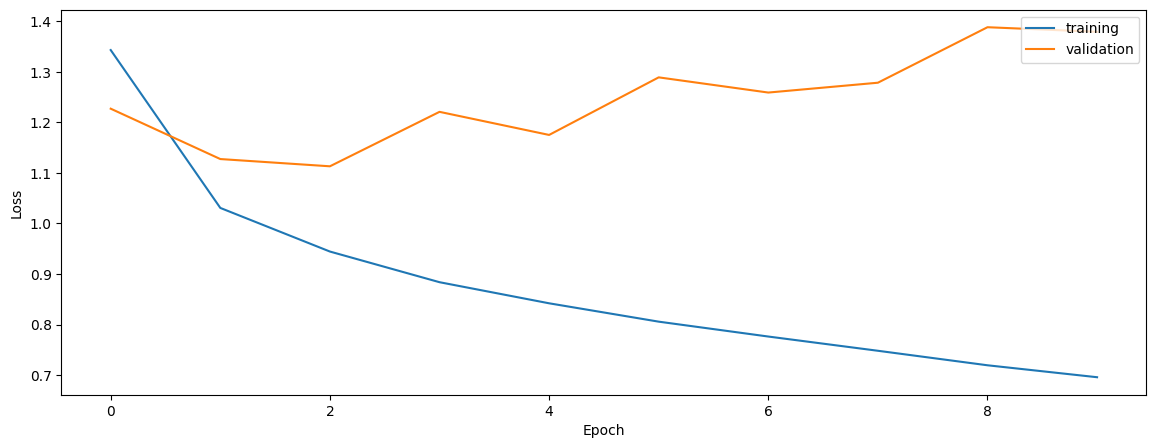

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6453057745707389
0.5590993404781534
0.6529226889250189


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5945562448861224
0.5532454962073325
0.5732950408542998


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.590317952444142
0.5654299255247123
0.5723126999767502


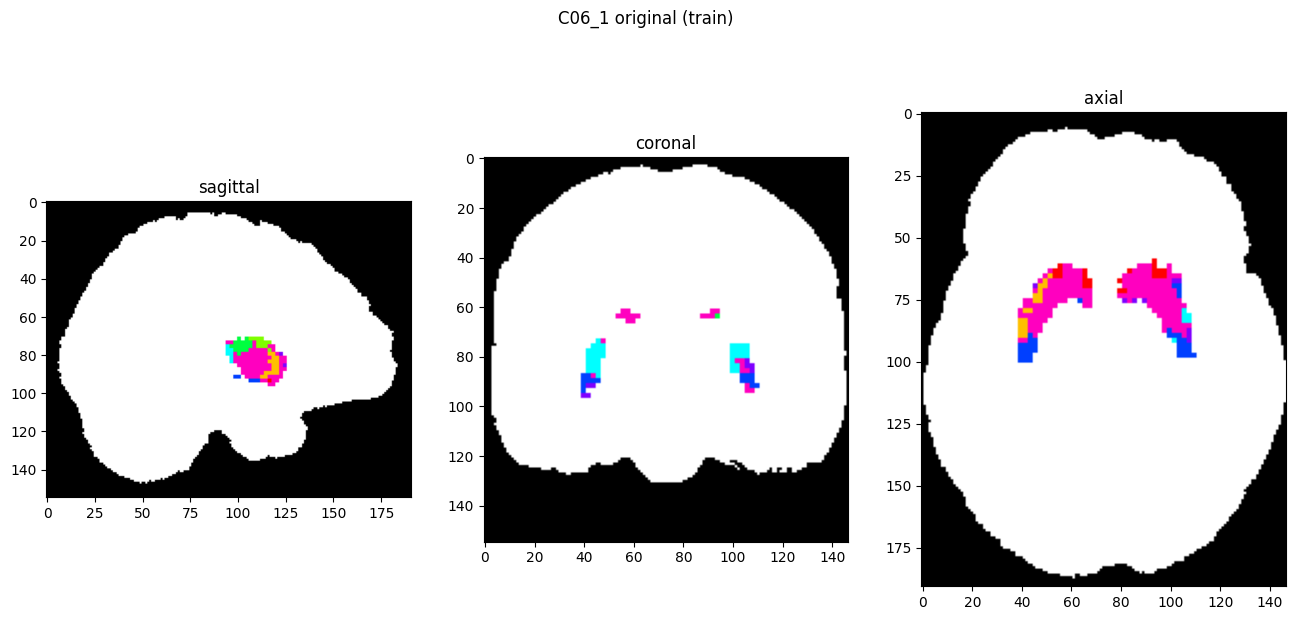

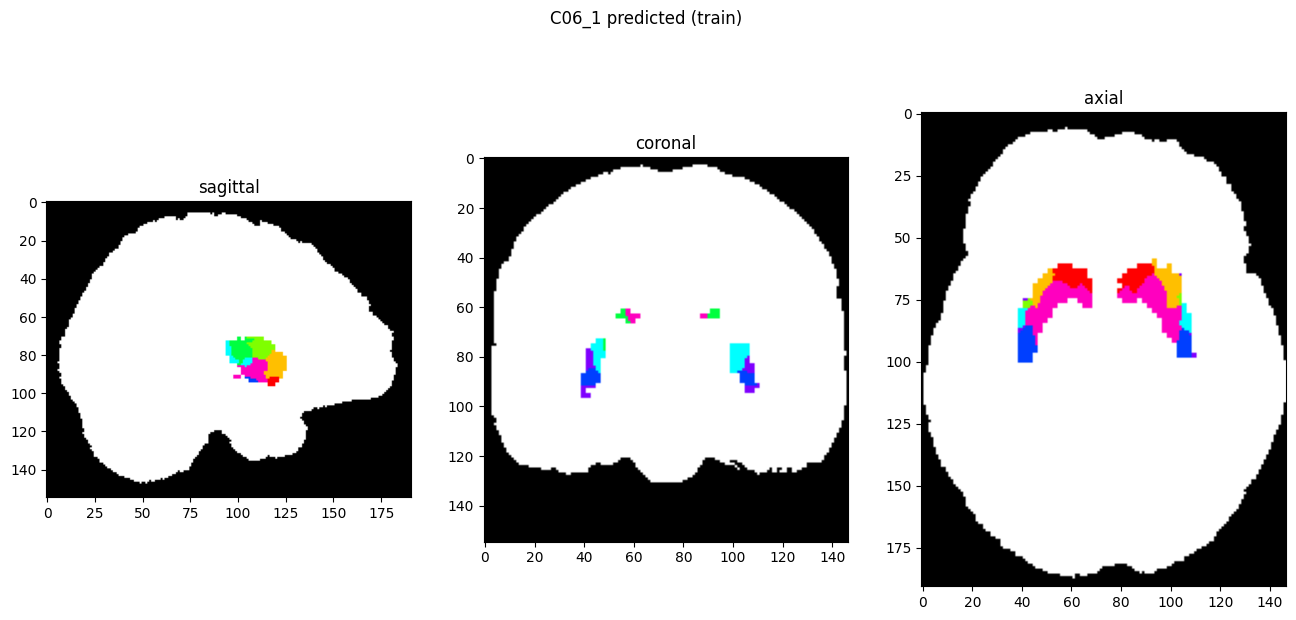

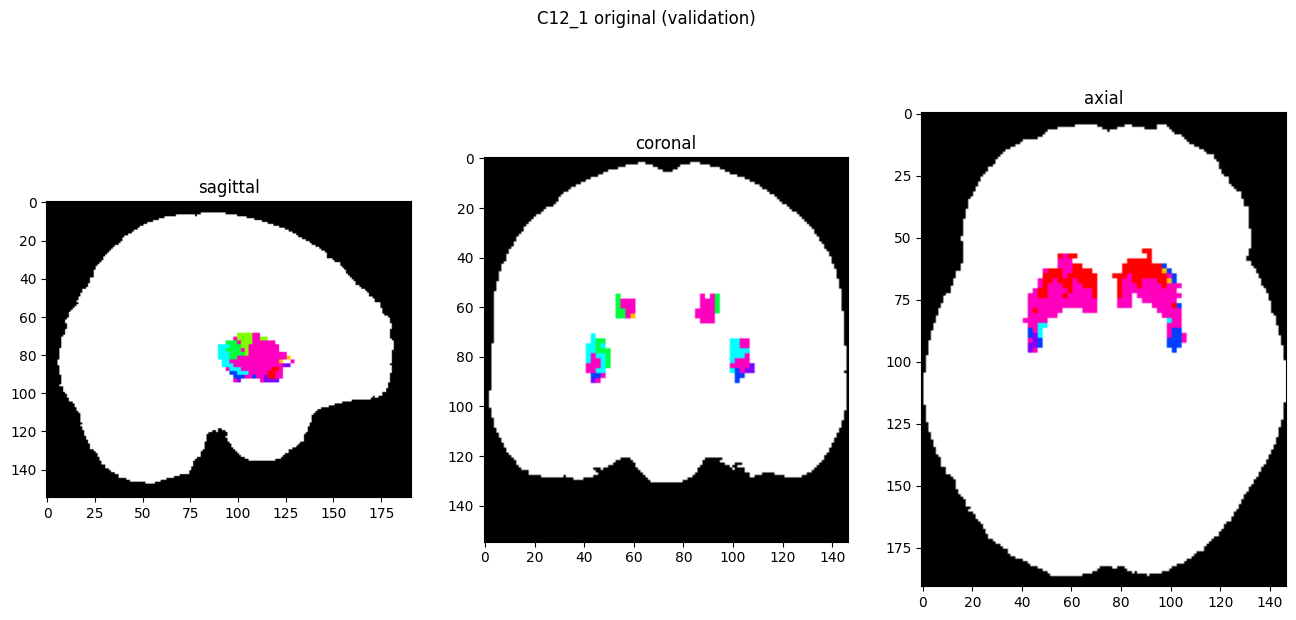

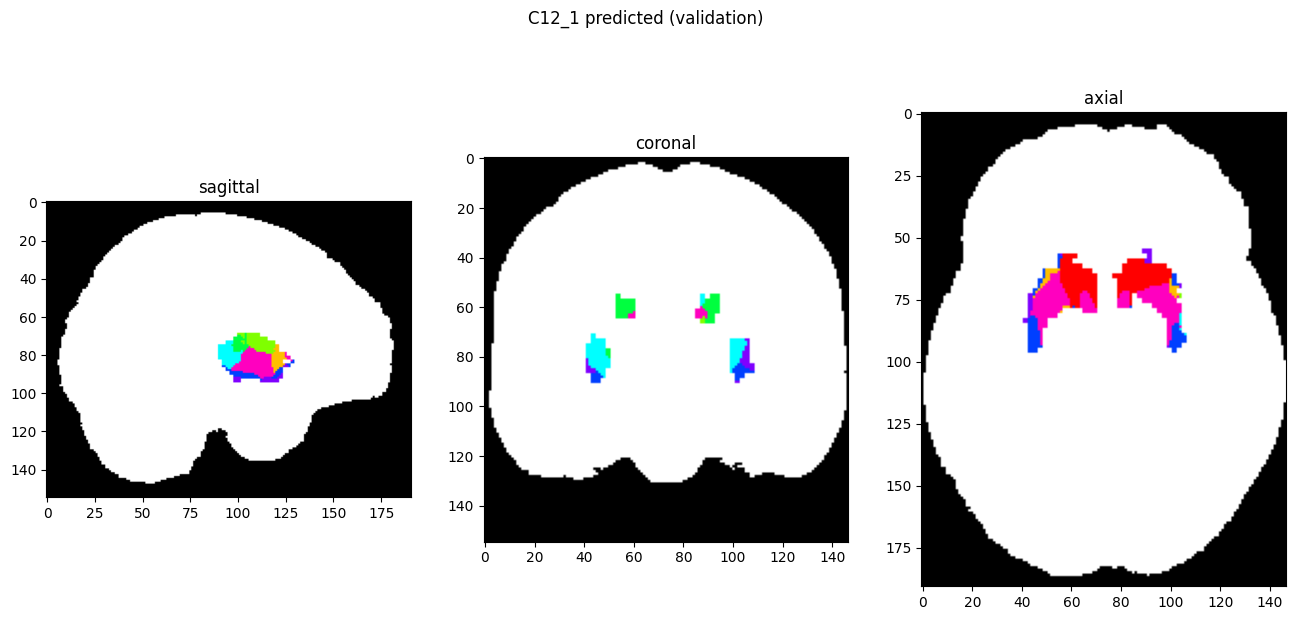

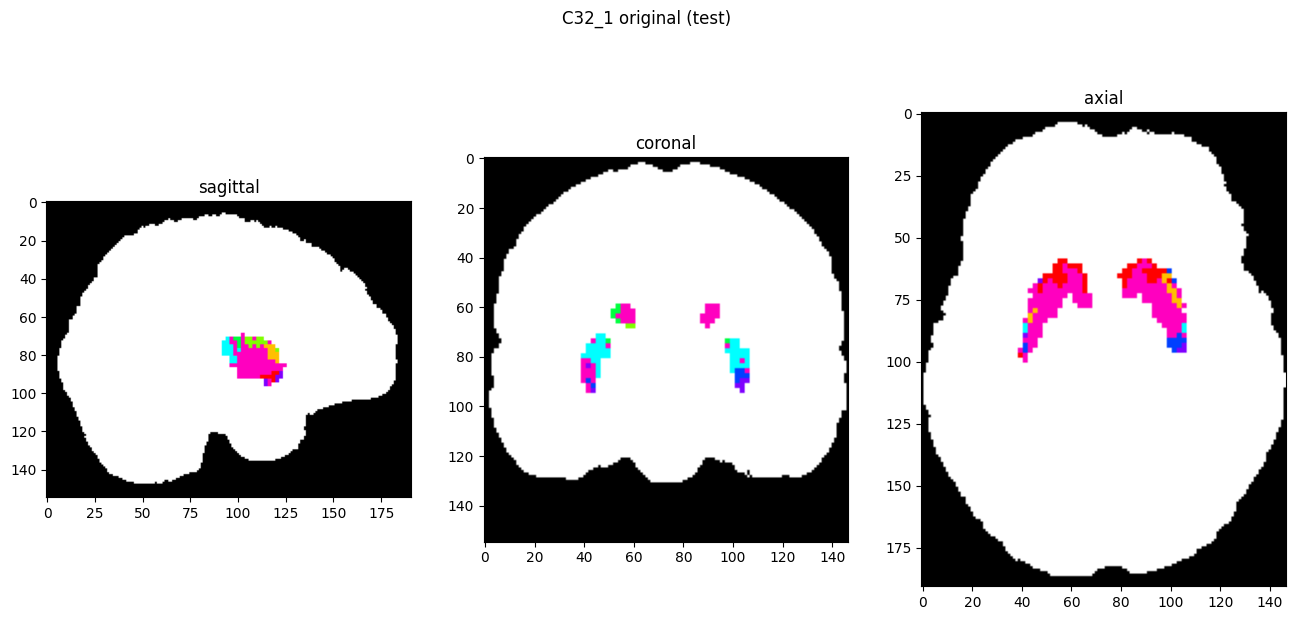

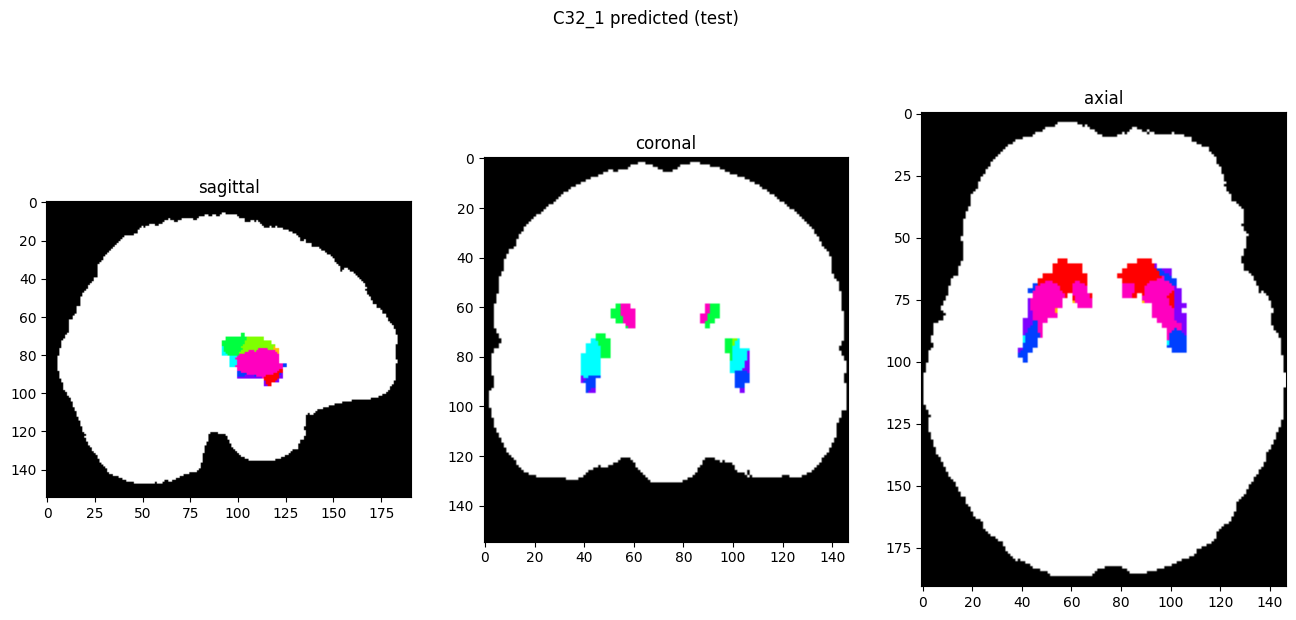

In [10]:
showResults(model, gen, threshold=0)